
EXTRACTED_ENTITIES:
dextromethorphan | CHEMICAL
dimemorfan | CHEMICAL
kainate | CHEMICAL
sigma1 receptor | GENE
dextromethorphan | CHEMICAL
dextromethorphan | CHEMICAL
dimemorfan | CHEMICAL
Dextromethorphan | CHEMICAL
dimemorfan | CHEMICAL
sigma1 receptors | GENE
Dextromethorphan | CHEMICAL
phencyclidine | CHEMICAL
dimemorfan | CHEMICAL
dimemorfan | CHEMICAL
Kainate | CHEMICAL
dimemorfan | CHEMICAL
Dimemorfan | CHEMICAL
c-fos | GENE
c-jun | GENE
activator protein (AP)-1 DNA-binding | GENE
dimemorfan | CHEMICAL
dextromethorphan | CHEMICAL
dextromethorphan | CHEMICAL
dimemorfan | CHEMICAL
sigma1 receptor | GENE
BD 1047 | CHEMICAL
dextromethorphan | CHEMICAL
dimemorfan | CHEMICAL
sigma1 receptor | GENE
AP-1 | GENE
dimemorfan | CHEMICAL
dextromethorphan | CHEMICAL
dextrorphan | CHEMICAL
phencyclidine | CHEMICAL
dextromethorphan | CHEMICAL
phencyclidine | CHEMICAL
dextrorphan | CHEMICAL
dextromethorphan | CHEMICAL
dimemorfan | CHEMICAL
dimemorfan | CHEMICAL
dextromethorphan | CHEMICAL

You

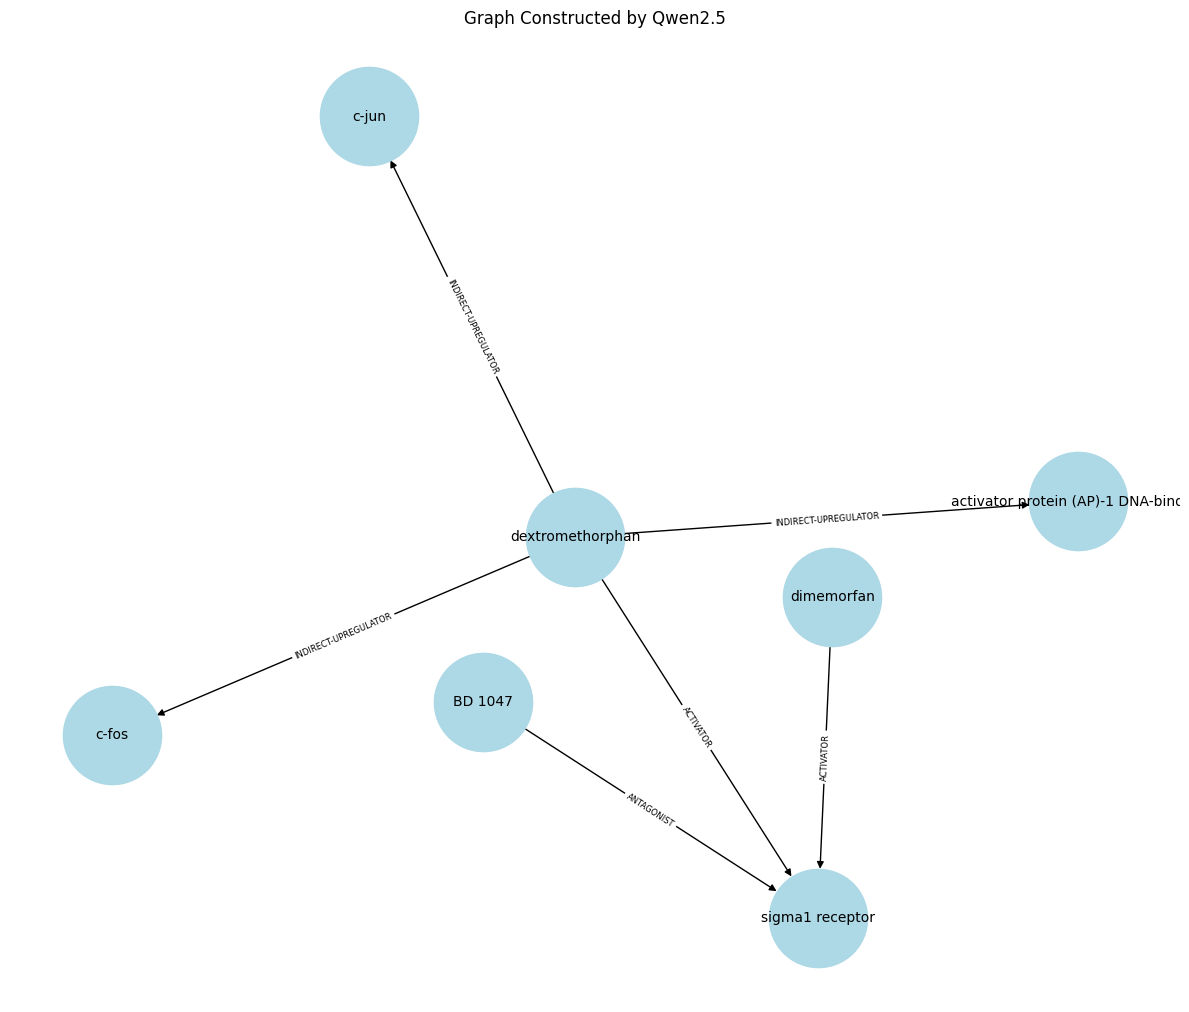

In [59]:
#Example Extraction
from strictjson import *
import json
from langchain_ollama import ChatOllama
import networkx as nx
import matplotlib.pyplot as plt
import spacy
nlp_ner = spacy.load("/home/rust/Downloads/IBMC/NLP/drugprot/spacy/output/model-best")

def llm(system_prompt: str, user_prompt: str) -> str:
    client = ChatOllama(
        base_url = "http://localhost:11434",
        model="qwen2.5:latest", 
        timeout=600, 
        temperature = 0.0,
        disable_streaming = True,
        num_ctx=4096
    )
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]
    ai_msg = client.invoke(messages)
    
    return ai_msg.content

Predicate = [
    "INDIRECT-DOWNREGULATOR",
    "INDIRECT-UPREGULATOR",
    "DIRECT-REGULATOR",
    "ACTIVATOR",
    "INHIBITOR",
    "AGONIST",
    "AGONIST-ACTIVATOR",
    "ANTAGONIST",
    "PRODUCT-OF",
    "SUBSTRATE",
    "SUBSTRATE_PRODUCT-OF",
    "PART-OF"
]


JSONs = {
    "CHEMICAL_NAME": "Has to be a name of only one CHEMICAL, type: string",
    "Predicate": f"type: Enum{Predicate}",
    "GENE_NAME": "Has to be a name of only one GENE, type: string",
    "Text_fragment": "Quote the parts of the text which ***DIRECTLY*** imply the relationship, type: list[string]",
    "Explanation": "Quote the part of ANNOTATION MANUAL that was used to derive the relationship, type: string",
}


output_format = {
    "Relationships": f"type: array{JSONs}"
}

user_prompt = """
TEXT:
The dextromethorphan analog dimemorfan attenuates kainate-induced seizures via sigma1 receptor activation: comparison with the effects of dextromethorphan.
In a previous study, we demonstrated that a dextromethorphan analog, dimemorfan, has neuroprotective effects. Dextromethorphan and dimemorfan are high-affinity ligands at sigma1 receptors. Dextromethorphan has moderate affinities for phencyclidine sites, while dimemorfan has very low affinities for such sites, suggesting that these sites are not essential for the anticonvulsant actions of dimemorfan. Kainate (KA) administration (10 mg kg(-1), i.p.) produced robust convulsions lasting 4-6 h in rats. Pre-treatment with dimemorfan (12 or 24 mg kg(-1)) reduced seizures in a dose-dependent manner. Dimemorfan pre-treatment also attenuated the KA-induced increases in c-fos/c-jun expression, activator protein (AP)-1 DNA-binding activity, and loss of cells in the CA1 and CA3 fields of the hippocampus. These effects of dimemorfan were comparable to those of dextromethorphan. The anticonvulsant action of dextromethorphan or dimemorfan was significantly counteracted by a selective sigma1 receptor antagonist BD 1047, suggesting that the anticonvulsant action of dextromethorphan or dimemorfan is, at least in part, related to sigma1 receptor-activated modulation of AP-1 transcription factors. We asked whether dimemorfan produces the behavioral side effects seen with dextromethorphan or dextrorphan (a phencyclidine-like metabolite of dextromethorphan). Conditioned place preference and circling behaviors were significantly increased in mice treated with phencyclidine, dextrorphan or dextromethorphan, while mice treated with dimemorfan showed no behavioral side effects. Our results suggest that dimemorfan is equipotent to dextromethorphan in preventing KA-induced seizures, while it may lack behavioral effects, such as psychotomimetic reactions.
"""

doc = nlp_ner(user_prompt)
entities = []  
for entity in doc.ents:
    entities.append(f"{entity.text} | {entity.label_}")

entities_str = "\n".join(entities).replace('"', "'").strip()

system_prompt = f"""
EXTRACTED_ENTITIES:
{entities_str}

You are an expert in molecular biology, biochemistry and pharmacology.
You are tasked with extracting ***ALL POSSIBLE*** CHEMICAL-GENE relationships between EXTRACTED ENTITIES from the provided TEXT.
Use the ANNOTATION MANUAL provided below to derive relationships from TEXT. 

# ANNOTATION MANUAL:
### GENE: gene, protein, receptor, enzyme or miRNA.
### CHEMICAL: chemical compound or drug which is not GENE
### INDIRECT-DOWNREGULATOR: A CHEMICAL that downregulates a GENE via other GENEs.
### INDIRECT-UPREGULATOR: A CHEMICAL that upregulates a GENE through the action of other GENEs.
### DIRECT-REGULATOR: A CHEMICAL that binds directly to a GENE, altering its activity or function.
### ACTIVATOR: A CHEMICAL that binds to a GENE and increases its activity.
### INHIBITOR: A CHEMICAL that binds to a GENE and decreases its activity.
### AGONIST: A CHEMICAL that binds to a GENE, changing its state and resulting in a biological response.
### AGONIST-ACTIVATOR: AGONIST that binds to a GENE and enhances its biological response.
### AGONIST-INHIBITOR: AGONIST that binds to a GENE and decrease its biological response
### ANTAGONIST: A CHEMICAL that reduces the effect of another CHEMICAL on a GENE, typically an AGONIST.
### PRODUCT-OF: A CHEMICAL that is produced by a GENE (usually enzyme).
### SUBSTRATE: A CHEMICAL that is acted upon by a GENE (usually enzyme).
### SUBSTRATE_PRODUCT-OF: A CHEMICAL that serves as both a SUBSTRATE and a PRODUCT-OF of GENE (usually enzyme).
### PART-OF: A CHEMICAL that is structurally related to a GENE.
"""

print(system_prompt)

result = strict_json(
    system_prompt=system_prompt,
    user_prompt=user_prompt,
    output_format=output_format,
    llm=llm,
    num_tries=1,
    return_json=True
)

pretty_json = json.dumps(result, indent=4)
print(pretty_json)
data = json.loads(pretty_json)

# Create a graph
G1 = nx.DiGraph()
for relationship in data['Relationships']:
    
    chemical_name = relationship['CHEMICAL_NAME']
    gene_name = relationship['GENE_NAME']
    predicate = relationship['Predicate']

    if chemical_name not in G1.nodes:
        G1.add_node(chemical_name)
    if gene_name not in G1.nodes:
        G1.add_node(gene_name)
        
    G1.add_edge(chemical_name, gene_name, label=predicate)

plt.figure(figsize=(12, 10)) 
pos = nx.spring_layout(G1, k=1.0)
nx.draw_networkx(G1, pos, with_labels=True, node_color='lightblue', node_size=5000, font_size=10)
edge_labels = {(u, v): d['label'] for u, v, d in G1.edges(data=True)}
nx.draw_networkx_edge_labels(G1, pos, edge_labels=edge_labels, font_size=6, rotate=True)  
plt.axis('off')  
plt.tight_layout()  
plt.title('Graph Constructed by Qwen2.5')
plt.show()


EXTRACTED_ENTITIES:
sugar | CHEMICAL
monosaccharides | CHEMICAL
carbohydrate response element-binding protein | GENE
ChREBP | GENE
ChREBP | GENE
ChREBP | GENE
fructose | CHEMICAL
ChREBP | GENE
triglyceride | CHEMICAL
fructose | CHEMICAL
ACC2 | GENE
FAS | GENE
SCD1 | GENE
triglyceride | CHEMICAL
insulin | GENE
glucose | CHEMICAL
ChREBP | GENE
insulin | GENE
fructose | CHEMICAL
ChREBP | GENE
uric acid | CHEMICAL
alanine transaminase | GENE
aspartate aminotransferase | GENE
fructose aldolase | GENE
fructokinase | GENE
fructose | CHEMICAL
ChREBP | GENE
fructose | CHEMICAL
insulin | GENE

You are a helpful relationship extractor. You are also an expert in molecular biology, biochemistry and pharmacology.
You are tasked with extracting CHEMICAL-GENE relationships between EXTRACTED ENTITIES while using the provided TEXT.
Use the ANNOTATION MANUAL provided below to derive relationships from TEXT. 

# ANNOTATION MANUAL:
### GENE: gene, protein, receptor, enzyme or miRNA.
### CHEMICAL: chemical

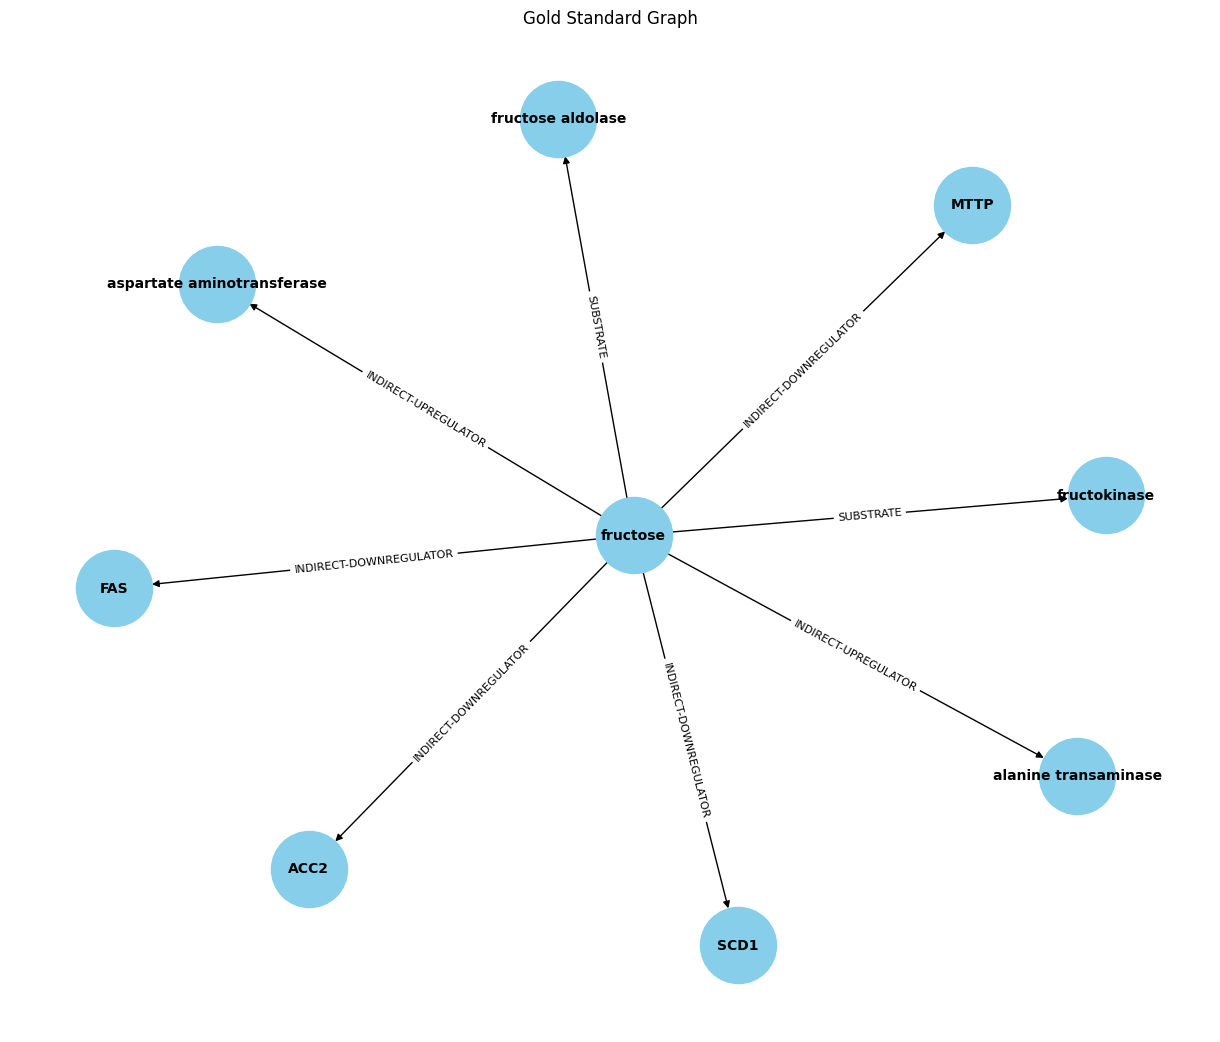

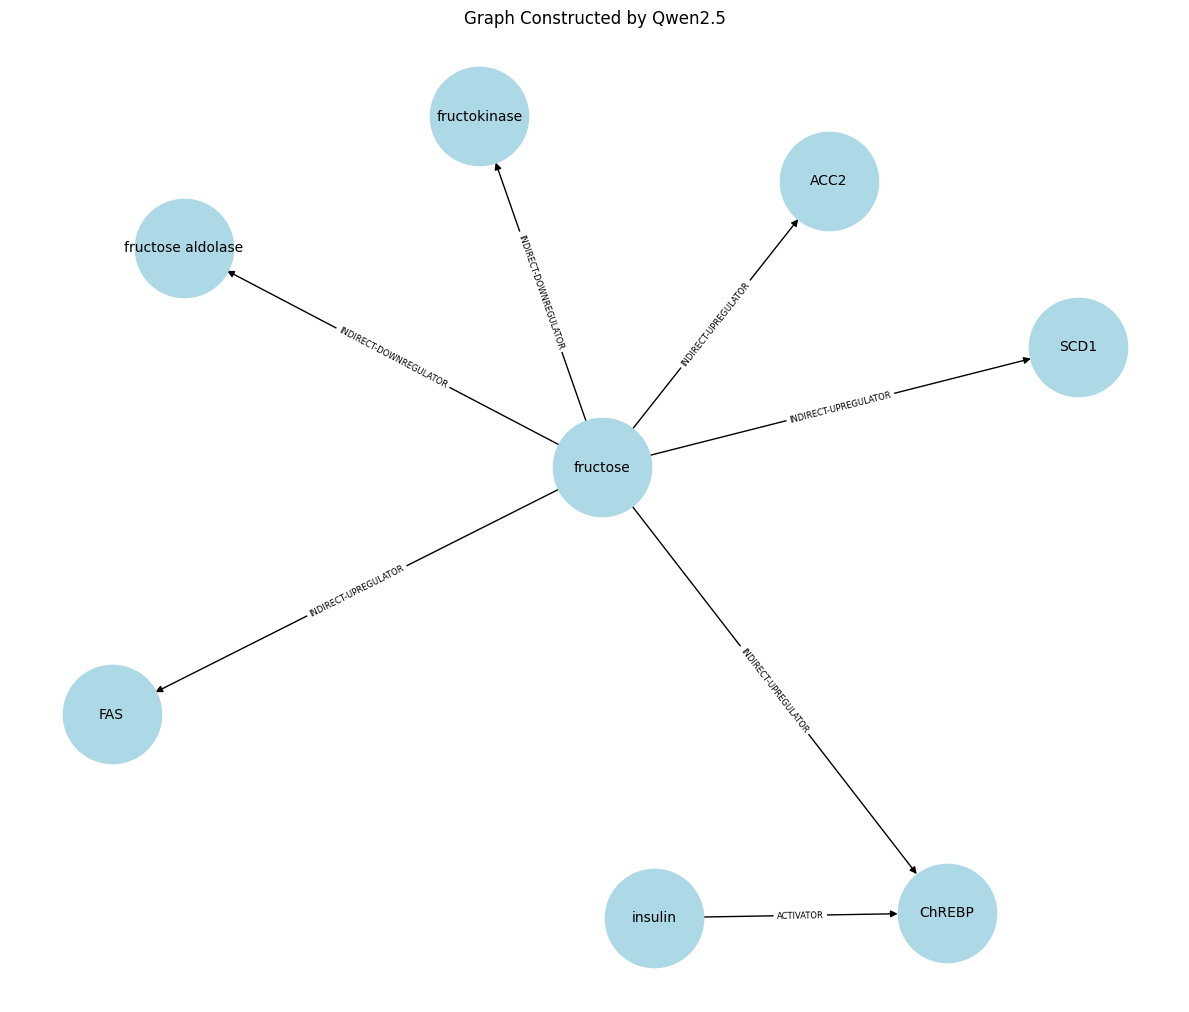

Edit Distance is 4.0


In [49]:
#Example Extraction with graphs
from strictjson import *
import json
from langchain_ollama import ChatOllama
import networkx as nx
import matplotlib.pyplot as plt
import spacy
nlp_ner = spacy.load("/home/rust/Downloads/IBMC/NLP/drugprot/spacy/output/model-best")

def llm(system_prompt: str, user_prompt: str) -> str:
    client = ChatOllama(
        base_url = "http://localhost:11434",
        model="qwen2.5:latest", 
        timeout=600, 
        temperature = 0.0,
        disable_streaming = True,
        num_ctx=4096
    )
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]
    ai_msg = client.invoke(messages)
    
    return ai_msg.content

Predicate = [
    "INDIRECT-DOWNREGULATOR",
    "INDIRECT-UPREGULATOR",
    "DIRECT-REGULATOR",
    "ACTIVATOR",
    "INHIBITOR",
    "AGONIST",
    "AGONIST-ACTIVATOR",
    "ANTAGONIST",
    "PRODUCT-OF",
    "SUBSTRATE",
    "SUBSTRATE_PRODUCT-OF",
    "PART-OF"
]


JSONs = {
    "CHEMICAL_NAME": "Has to be a name of only one CHEMICAL, type: string",
    "Predicate": f"type: Enum{Predicate}",
    "GENE_NAME": "Has to be a name of only one GENE, type: string",
    "Text_fragment": "Paraphrase the parts of the text which imply the relationship",
    "Explanation": "Paraphrase the part of ANNOTATION MANUAL that was used to derive the relationship, type: string",
}


output_format = {
    "Relationships": f"type: array{JSONs}"
}

user_prompt = """
TEXT:
By 2030, nearly half of Americans will have nonalcoholic fatty liver disease. 
In part, this epidemic is fueled by the increasing consumption of caloric sweeteners coupled with an 
innate capacity to convert sugar into fat via hepatic de novo lipogenesis. In addition to serving as 
substrates, monosaccharides also increase the expression of key enzymes involved in de novo lipogenesis via 
the carbohydrate response element-binding protein (ChREBP). To determine whether ChREBP is a potential therapeutic 
target, we decreased hepatic expression of ChREBP with a specific antisense oligonucleotide (ASO) in male 
Sprague-Dawley rats fed either a high-fructose or high-fat diet. ChREBP ASO treatment decreased plasma 
triglyceride concentrations compared with control ASO treatment in both diet groups. The reduction was more 
pronounced in the fructose-fed group and attributed to decreased hepatic expression of ACC2, FAS, SCD1, and 
MTTP and a decrease in the rate of hepatic triglyceride secretion. This was associated with an increase in 
insulin-stimulated peripheral glucose uptake, as assessed by the hyperinsulinemic-euglycemic clamp. In contrast, 
ChREBP ASO did not alter hepatic lipid content or hepatic insulin sensitivity. Interestingly, fructose-fed rats 
treated with ChREBP ASO had increased plasma uric acid, alanine transaminase, and aspartate aminotransferase 
concentrations. This was associated with decreased expression of fructose aldolase and fructokinase, 
reminiscent of inherited disorders of fructose metabolism. In summary, these studies suggest that targeting 
ChREBP may prevent fructose-induced hypertriglyceridemia but without the improvements in hepatic steatosis and 
hepatic insulin responsiveness.
"""

doc = nlp_ner(user_prompt)
entities = []  # Initialize a list to store entity information
for entity in doc.ents:
    entities.append(f"{entity.text} | {entity.label_}")  # Add each entity to the list

entities_str = "\n".join(entities).replace('"', "'").strip()

system_prompt = f"""
EXTRACTED_ENTITIES:
{entities_str}

You are a helpful relationship extractor. You are also an expert in molecular biology, biochemistry and pharmacology.
You are tasked with extracting CHEMICAL-GENE relationships between EXTRACTED ENTITIES while using the provided TEXT.
Use the ANNOTATION MANUAL provided below to derive relationships from TEXT. 

# ANNOTATION MANUAL:
### GENE: gene, protein, receptor, enzyme or miRNA.
### CHEMICAL: chemical compound or drug which is not GENE
### INDIRECT-DOWNREGULATOR: A CHEMICAL that downregulates a GENE via other GENEs.
### INDIRECT-UPREGULATOR: A CHEMICAL that upregulates a GENE through the action of other GENEs.
### DIRECT-REGULATOR: A CHEMICAL that binds directly to a GENE, altering its activity or function.
### ACTIVATOR: A CHEMICAL that binds to a GENE and increases its activity.
### INHIBITOR: A CHEMICAL that binds to a GENE and decreases its activity.
### AGONIST: A CHEMICAL that binds to a GENE, changing its state and resulting in a biological response.
### AGONIST-ACTIVATOR: AGONIST that binds to a GENE and enhances its biological response.
### AGONIST-INHIBITOR: AGONIST that binds to a GENE and decrease its biological response
### ANTAGONIST: A CHEMICAL that reduces the effect of another CHEMICAL on a GENE, typically an AGONIST.
### PRODUCT-OF: A CHEMICAL that is produced by a GENE (usually enzyme).
### SUBSTRATE: A CHEMICAL that is acted upon by a GENE (usually enzyme).
### SUBSTRATE_PRODUCT-OF: A CHEMICAL that serves as both a SUBSTRATE and a PRODUCT-OF of GENE (usually enzyme).
### PART-OF: A CHEMICAL that is structurally related to a GENE.
"""

print(system_prompt)

result = strict_json(
    system_prompt=system_prompt,
    user_prompt=user_prompt,
    output_format=output_format,
    llm=llm,
    num_tries=1,
    return_json=True
)

pretty_json = json.dumps(result, indent=4)
print(pretty_json)
data = json.loads(pretty_json)

# Create a graph
G1 = nx.DiGraph()
for relationship in data['Relationships']:
    
    chemical_name = relationship['CHEMICAL_NAME']
    gene_name = relationship['GENE_NAME']
    predicate = relationship['Predicate']

    if chemical_name not in G1.nodes:
        G1.add_node(chemical_name)
    if gene_name not in G1.nodes:
        G1.add_node(gene_name)
        
    G1.add_edge(chemical_name, gene_name, label=predicate)

d = {
    "Relationships": [
        {
            'CHEMICAL_NAME': [
                'fructose',
                'fructose',
                'fructose',
                'fructose',
                'fructose',
                'fructose',
                'fructose',
                'fructose',
            ],
            'GENE_NAME': [
                "ACC2",
                "FAS",
                "SCD1",
                "MTTP",
                "alanine transaminase",
                "aspartate aminotransferase",
                "fructose aldolase",
                "fructokinase"
            ],
            'Predicate': [
                "INDIRECT-DOWNREGULATOR",
                "INDIRECT-DOWNREGULATOR",
                "INDIRECT-DOWNREGULATOR",
                "INDIRECT-DOWNREGULATOR",
                "INDIRECT-UPREGULATOR",
                "INDIRECT-UPREGULATOR",
                "SUBSTRATE",
                "SUBSTRATE"
            ]
        }
    ]
}

chemical_names = d["Relationships"][0]['CHEMICAL_NAME']
gene_names = d["Relationships"][0]['GENE_NAME']
predicates = d["Relationships"][0]['Predicate']

G2 = nx.DiGraph()

for i in range(len(chemical_names)):
    G2.add_edge(chemical_names[i], gene_names[i], label=predicates[i])

plt.figure(figsize=(12, 10)) 
pos = nx.spring_layout(G2)
nx.draw(G2, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold")
edge_labels = nx.get_edge_attributes(G2, 'label')
nx.draw_networkx_edge_labels(G2, pos, edge_labels=edge_labels, font_size=8)

plt.title('Gold Standard Graph')
plt.show()


plt.figure(figsize=(12, 10)) 
pos = nx.spring_layout(G1, k=1.0)
nx.draw_networkx(G1, pos, with_labels=True, node_color='lightblue', node_size=5000, font_size=10)
edge_labels = {(u, v): d['label'] for u, v, d in G1.edges(data=True)}
nx.draw_networkx_edge_labels(G1, pos, edge_labels=edge_labels, font_size=6, rotate=True)  
plt.axis('off')  
plt.tight_layout()  
plt.title('Graph Constructed by Qwen2.5')
plt.show()

print(f"Edit Distance is {nx.graph_edit_distance(G1, G2)}")


In [ ]:
#Extract JSONs for each row in drugprot_abstracts.csv
from strictjson import *
import json
from json_repair import repair_json
from langchain_ollama import ChatOllama
import os
import pandas as pd
from langchain_core.messages import AIMessage
from tqdm import tqdm

df = pd.read_csv('./training/drugprot_.csv', sep=',')
df['JSON'] = None

def llm(system_prompt: str, user_prompt: str) -> str:
    client = ChatOllama(
        base_url = "http://localhost:11434",
        model="qwen2.5:latest", 
        timeout=600, 
        temperature = 0.0,
        disable_streaming = True,
        num_ctx=4096
    )
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]
    ai_msg = client.invoke(messages)
    
    return ai_msg.content


Predicate = [
    "INDIRECT-DOWNREGULATOR",
    "INDIRECT-UPREGULATOR",
    "DIRECT-REGULATOR",
    "ACTIVATOR",
    "INHIBITOR",
    "AGONIST",
    "AGONIST-ACTIVATOR",
    "ANTAGONIST",
    "PRODUCT-OF",
    "SUBSTRATE",
    "SUBSTRATE_PRODUCT-OF",
    "PART-OF"
]

Entity_1_class = ["CHEMICAL", "GENE"]

Entity_2_class = ["CHEMICAL", "GENE"]



JSONs = {
    "Entity_1_name": "type: string",
    "Entity_1_class": f"One of two classes, type: array{Entity_1_class}",
    "Predicate": f"type: Enum{Predicate}",
    "Entity_2_name": "type: string",
    "Entity_2_class": f"One of two classes, type: array{Entity_2_class}"
}


output_format = {
    "Relationship": f"type: array{JSONs}"
}

system_prompt = """
Annotation manual:
# GENE: Genes, proteins, enzymes, miRNAs.
# CHEMICAL: Chemical entities (compounds) and drugs (***NOT genes, proteins, enzymes, miRNAs***).
# DIRECT-REGULATOR: Chemical entity that binds to gene or protein through a direct physical interaction and changes its activity or function.
# INDIRECT-UPREGULATOR: Chemical entity upregulates gene or protein via other target.
# INDIRECT-DOWNREGULATOR: Chemical entity downregulates gene or protein via other target.
# INHIBITOR: Chemical entity that binds to gene or protein and decreases its activity.
# ACTIVATOR: Chemical entity that binds to gene or protein and increases its activity. (for example, dicarboxylate glutarate binds to rabbit Na(+)-dicarboxylate cotransporter 1, increasing its activity)
# ANTAGONIST: Chemical entity that reduces the action of another chemical entity, generally an agonist.
# AGONIST: Chemical entity that binds to a receptor and alters the receptor state resulting in a biological response.
# AGONIST-ACTIVATOR: Agonist that binds to a receptor and increases its biological response.
# PRODUCT-OF: Chemical entity that is a product of enzymatic reaction or a transporter.
# SUBSTRATE: Chemical entity upon which gene or protein acts.
# SUBSTRATE_PRODUCT-OF: Chemical entity that is both a substrate and product of enzymatic reaction.
# PART-OF: Chemical entity that is structurally related to a gene or protein (for example a specific amino acid residue of a protein).

You are a helpful CHEMICAL-GENE binary relations extractor. 
Extract all possible binary relations from the given text based on the annotation manual above, focusing ***ONLY*** on CHEMICAL and GENE entities in the text. 
Rely ***only*** on knowledge given in the text.

### Instructions:
1. Identify **both entities** involved in each relationship (e.g., Entity_1 and Entity_2), ensuring that Entity_1 is CHEMICAL and Entity_2 is GENE
2. Extract relationships between these entities based on the annotation manual.
3. Label genes, proteins or enzymes as GENE and any other chemical entity as CHEMICAL.
4. Do not extract GENE-GENE or CHEMICAL-CHEMICAL relationships. 
5. Any gene, protein, enzyme and miRNA is GENE; any chemical entity (compound) and drug is CHEMICAL.
"""

for index, abstract in tqdm(enumerate(df['Abstract']), total=len(df['Abstract']), desc="Processing Abstracts"):
    result = strict_json(
        system_prompt=system_prompt,
        user_prompt=abstract,
        output_format=output_format,
        llm=llm,
        num_tries=1,
        return_json=True
    )
    df.at[index, "JSON"] = result
    if index % 2 == 0:
        df.to_csv("./training/drugprot_.csv", index=False)

df.to_csv("./training/drugprot_.csv", index=False)


print(result)

In [6]:
#Prompt experiment 2
from strictjson import *
import json
from langchain_ollama import ChatOllama
import networkx as nx
import matplotlib.pyplot as plt

def llm(system_prompt: str, user_prompt: str) -> str:
    client = ChatOllama(
        base_url = "http://localhost:11434",
        model="qwen2.5:latest", 
        timeout=600, 
        temperature = 0.0,
        disable_streaming = True,
        num_ctx=4096
    )
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]
    ai_msg = client.invoke(messages)
    
    return ai_msg.content

Predicate = [
    "INDIRECT-DOWNREGULATOR",
    "INDIRECT-UPREGULATOR",
    "DIRECT-REGULATOR",
    "ACTIVATOR",
    "INHIBITOR",
    "AGONIST",
    "AGONIST-ACTIVATOR",
    "AGONIST-INHIBITOR",
    "ANTAGONIST",
    "PRODUCT-OF",
    "SUBSTRATE",
    "SUBSTRATE_PRODUCT-OF",
    "PART-OF"
]


entities = {
    "Entity_number": "Write T[int], type: string",
    "Type": "GENE or CHEMICAL, type: Enum[string]",
    "Text string of entity": "Specific entity, type: string"
}



relations = {
    "Predicate": f"type: Enum{Predicate}",
    "Arguments": [
        {
            "name": "Arg1",
            "Entity_number": "Write T[int], type: string",
            "Text string of entity": "Specific entity and should be CHEMICAL, type: string"
        },
        {
            "name": "Arg2",
            "Entity_number": "Write T[int], type: string",
            "Text string of entity": "Specific entity and should be GENE, type: string"
        }
        ]
}


output_format = {
    "Entities": f"type: array{entities}",
    "Relationships": f"type: array{relations}"
}


user_prompt = """
By 2030, nearly half of Americans will have nonalcoholic fatty liver disease. 
In part, this epidemic is fueled by the increasing consumption of caloric sweeteners coupled with an 
innate capacity to convert sugar into fat via hepatic de novo lipogenesis. In addition to serving as 
substrates, monosaccharides also increase the expression of key enzymes involved in de novo lipogenesis via 
the carbohydrate response element-binding protein (ChREBP). To determine whether ChREBP is a potential therapeutic 
target, we decreased hepatic expression of ChREBP with a specific antisense oligonucleotide (ASO) in male 
Sprague-Dawley rats fed either a high-fructose or high-fat diet. ChREBP ASO treatment decreased plasma 
triglyceride concentrations compared with control ASO treatment in both diet groups. The reduction was more 
pronounced in the fructose-fed group and attributed to decreased hepatic expression of ACC2, FAS, SCD1, and 
MTTP and a decrease in the rate of hepatic triglyceride secretion. This was associated with an increase in 
insulin-stimulated peripheral glucose uptake, as assessed by the hyperinsulinemic-euglycemic clamp. In contrast, 
ChREBP ASO did not alter hepatic lipid content or hepatic insulin sensitivity. Interestingly, fructose-fed rats 
treated with ChREBP ASO had increased plasma uric acid, alanine transaminase, and aspartate aminotransferase 
concentrations. This was associated with decreased expression of fructose aldolase and fructokinase, 
reminiscent of inherited disorders of fructose metabolism. In summary, these studies suggest that targeting 
ChREBP may prevent fructose-induced hypertriglyceridemia but without the improvements in hepatic steatosis and 
hepatic insulin responsiveness.
"""

system_prompt = """
You are a helpful entity and relationship extractor.
Extract relationships between chemical compounds/drug and genes/proteins based *SOLELY* on the ANNOTATION MANUAL provided below.

# ANNOTATION MANUAL:

## Entities:
### GENE: *Singular specific* gene, protein, receptor, enzyme or miRNA.
### CHEMICAL: "Singular specific" chemical compound/drug which is not GENE

## Relationships:
### INDIRECT-DOWNREGULATOR: A CHEMICAL that downregulates a GENE via other GENEs.
### INDIRECT-UPREGULATOR: A CHEMICAL that upregulates a GENE through the action of other GENEs.
### DIRECT-REGULATOR: A CHEMICAL that binds directly to a GENE, altering its activity or function.
### ACTIVATOR: A CHEMICAL that binds to a GENE and increases its activity.
### INHIBITOR: A CHEMICAL that binds to a GENE and decreases its activity.
### AGONIST: A CHEMICAL that binds to a GENE, changing its state and resulting in a biological response.
### AGONIST-ACTIVATOR: AGONIST that binds to a GENE and enhances its biological response.
### AGONIST-INHIBITOR: AGONIST that binds to a GENE and decrease its biological response
### ANTAGONIST: A CHEMICAL that reduces the effect of another CHEMICAL on a GENE, typically an AGONIST.
### PRODUCT-OF: A CHEMICAL that is produced by a GENE (usually enzyme).
### SUBSTRATE: A CHEMICAL that is acted upon by a GENE (usually enzyme).
### SUBSTRATE_PRODUCT-OF: A CHEMICAL that serves as both a SUBSTRATE and a PRODUCT-OF of GENE (usually enzyme).
### PART-OF: A CHEMICAL that is structurally related to a GENE.

# EXAMPLE TEXT:
Three retinol dehydrogenases (RDHs) were tested for steroid converting abilities: human and murine RDH 12 and 
human RDH13. RDH12 is involved in retinal degeneration in Leber's congenital amaurosis (LCA). 
We show that murine Rdh12 and human RDH13 do not reveal activity towards the checked steroids, but that 
human type 12 RDH reduces dihydrotestosterone to androstanediol, and is thus also involved in steroid metabolism. 
Furthermore, we analyzed both expression and subcellular localization of these enzymes.

# EXAMPLE EXTRACTED ENTITIES:
[
  {
    "Entity number": "T1",
    "type": "CHEMICAL",
    "Text string of entity": "androstanediol"
  },
  {
    "Entity number": "T2",
    "type": "CHEMICAL",
    "Text string of entity": "retinol"
  },
  {
    "Entity number": "T3",
    "type": "CHEMICAL",
    "Text string of entity": "retinol"
  },
  {
    "Entity number": "T4",
    "type": "GENE",
    "Text string of entity": "human RDH13"
  },
  {
    "Entity number": "T5",
    "type": "GENE",
    "Text string of entity": "RDH12"
  },
  {
    "Entity number": "T6",
    "type": "GENE",
    "Text string of entity": "murine Rdh12"
  },
  {
    "Entity number": "T7",
    "type": "GENE",
    "Text string of entity": "human RDH13"
  },
  {
    "Entity number": "T8",
    "type": "GENE",
    "Text string of entity": "RDHs"
  },
  {
    "Entity number": "T9",
    "type": "GENE",
    "Text string of entity": "human type 12 RDH"
  },
  {
    "Entity number": "T10",
    "type": "GENE",
    "Text string of entity": "retinol dehydrogenases"
  },
  {
    "Entity number": "T11",
    "type": "GENE",
    "Text string of entity": "human and murine RDH 12"
  },
  {
    "Entity number": "T12",
    "type": "GENE",
    "Text string of entity": "RDH12"
  },
  {
    "Entity number": "T13",
    "type": "GENE",
    "Text string of entity": "retinol dehydrogenase"
  }
]
"""


result = strict_json(
    system_prompt=system_prompt,
    user_prompt=user_prompt,
    output_format=output_format,
    llm=llm,
    num_tries=1,
    return_json=True
)

pretty_json = json.dumps(result, indent=4)
print(pretty_json)
data = json.loads(pretty_json)




{
    "Entities": [
        {
            "Entity_number": "T1",
            "type": "CHEMICAL",
            "Text string of entity": "nonalcoholic fatty liver disease"
        },
        {
            "Entity_number": "T2",
            "type": "CHEMICAL",
            "Text string of entity": "caloric sweeteners"
        },
        {
            "Entity_number": "T3",
            "type": "CHEMICAL",
            "Text string of entity": "sugar"
        },
        {
            "Entity_number": "T4",
            "type": "CHEMICAL",
            "Text string of entity": "fat"
        },
        {
            "Entity_number": "T5",
            "type": "GENE",
            "Text string of entity": "ChREBP"
        },
        {
            "Entity_number": "T6",
            "type": "CHEMICAL",
            "Text string of entity": "ASO"
        },
        {
            "Entity_number": "T7",
            "type": "GENE",
            "Text string of entity": "male Sprague-Dawley rats"
        },
 

In [23]:
import pandas as pd

#df = pd.read_csv('./training/drugprot_training_entities.tsv', sep='\t')

#rows_with_string = df[df.iloc[:, 0].astype(str).str.contains('17512723')]
#rows_with_string
import pandas as pd
import json

col_names_1 = ['PMID', 'Title', 'Abstract']
col_names_2 = ['PMID', 'Arg', 'Type', 'Start_offset', 'End_offset', 'String' ]

df1 = pd.read_csv("./drugprot-gs-training-development/training/drugprot_training_abstracts.tsv", sep='\t', names=col_names_1)
df2 = pd.read_csv("./drugprot-gs-training-development/training/drugprot_training_entities.tsv", sep='\t', names=col_names_2)
print(df1.head(), df2.head())

       PMID                                              Title  \
0  17512723  RDH12, a retinol dehydrogenase causing Leber's...   
1  23557993  A diarylheptanoid phytoestrogen from Curcuma c...   
2  23161873  The role of the carbohydrate response element-...   
3  17292977  Biological activity of AC3174, a peptide analo...   
4  23348500  A novel metabotropic glutamate receptor 5 posi...   

                                            Abstract  
0  Three retinol dehydrogenases (RDHs) were teste...  
1  Curcuma comosa Roxb. is ginger-family plant us...  
2  By 2030, nearly half of Americans will have no...  
3  Exenatide, the active ingredient of BYETTA (ex...  
4  Metabotropic glutamate receptor 5 (mGlu5) is a...          PMID Arg      Type  Start_offset  End_offset     String
0  11808879  T1  CHEMICAL          1165        1174  diazoxide
1  11808879  T2  CHEMICAL          1450        1459  Diazoxide
2  11808879  T3  CHEMICAL          1901        1910  diazoxide
3  11808879  T4  CHEM

In [4]:
#Left join df1 (abstracts) and df2 (entities) for training set
import pandas as pd
import json
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm

col_names_1 = ['PMID', 'Title', 'Abstract']
col_names_2 = ['PMID', 'Arg', 'Type', 'Start_offset', 'End_offset', 'String' ]

df1 = pd.read_csv("./drugprot-gs-training-development/training/drugprot_training_abstracts.tsv", sep='\t', names=col_names_1)
df2 = pd.read_csv("./drugprot-gs-training-development/training/drugprot_training_entities.tsv", sep='\t', names=col_names_2)

print(len(df1), "\n", len(df2))

merged_df = pd.merge(df1, df2, how='inner', on='PMID')

merged_df['Title + Abstract'] = merged_df['Title'] + ' ' + merged_df['Abstract']
merged_df = merged_df[['PMID', 'Title + Abstract', 'Arg', 'Type', 'Start_offset', 'End_offset', 'String']]

df = merged_df.dropna()
df['Type'] = df['Type'].replace(['GENE-N', 'GENE-Y'], 'GENE')
df.to_csv('train.csv', index=False)

2150 
 89529


/tmp/ipykernel_5869/2445940484.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Type'] = df['Type'].replace(['GENE-N', 'GENE-Y'], 'GENE')


In [5]:
#Left join df1 (abstracts) and df2 (entities) for dev set
import pandas as pd
import json
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm

col_names_1 = ['PMID', 'Title', 'Abstract']
col_names_2 = ['PMID', 'Arg', 'Type', 'Start_offset', 'End_offset', 'String' ]

df1 = pd.read_csv("./drugprot-gs-training-development/development/drugprot_development_abstracs.tsv", sep='\t', names=col_names_1)
df2 = pd.read_csv("./drugprot-gs-training-development/development/drugprot_development_entities.tsv", sep='\t', names=col_names_2)

print(len(df1), "\n", len(df2))

merged_df = pd.merge(df1, df2, how='inner', on='PMID')

merged_df['Title + Abstract'] = merged_df['Title'] + ' ' + merged_df['Abstract']
merged_df = merged_df[['PMID', 'Title + Abstract', 'Arg', 'Type', 'Start_offset', 'End_offset', 'String']]

df = merged_df.dropna()
df.to_csv('dev.csv', index=False)

750 
 18858


In [11]:
# Concatenate train and dev

df1 = pd.read_csv('train.csv', sep=',')
df2 = pd.read_csv('dev.csv', sep=',')

frames = [df1, df2]

concatenated_df = pd.concat(frames)
concatenated_df = concatenated_df.dropna()
concatenated_df.to_csv('train+dev.csv', index=False)


In [15]:
#Prepare folds
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
import os
from collections import Counter
import random


df = pd.read_csv('train+dev.csv')

def prepare_robust_cv_folds(df, n_splits=5, random_state=42, min_class_size=5):
    """
    Improved version that handles rare document classes.
    
    Args:
        df: Input DataFrame
        n_splits: Number of CV folds
        random_state: Random seed
        min_class_size: Minimum class size for stratification (default=5)
                       Classes smaller than this will be grouped together
    """
    # Set random seeds
    random.seed(random_state)
    np.random.seed(random_state)
    
    # 1. Group by PMID
    grouped = df.groupby('PMID')
    pmids = list(grouped.groups.keys())
    
    # 2. Create robust stratification labels
    doc_strat_labels = []
    type_counter = Counter()
    
    # First pass: Count entity type combinations
    for pmid, group in grouped:
        type_counts = frozenset(Counter(group['Type']).items())
        type_counter[type_counts] += 1
    
    # Create mapping for rare classes
    label_map = {}
    current_label = 0
    for type_combo, count in type_counter.most_common():
        label_map[type_combo] = current_label if count >= min_class_size else -1
        current_label += 1
    
    # Second pass: Assign labels (grouping rare classes)
    for pmid, group in grouped:
        type_counts = frozenset(Counter(group['Type']).items())
        doc_strat_labels.append(label_map.get(type_counts, -1))
    
    # 3. Generate folds
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    folds = []
    
    for train_idx, val_idx in skf.split(pmids, doc_strat_labels):
        train_pmids = [pmids[i] for i in train_idx]
        val_pmids = [pmids[i] for i in val_idx]
        
        train_df = df[df['PMID'].isin(train_pmids)].copy()
        val_df = df[df['PMID'].isin(val_pmids)].copy()
        
        folds.append((train_df, val_df))
    
    return folds

def save_cv_folds_as_csv(df, output_dir='cv_folds', n_splits=5, random_state=42):
    """
    Save stratified CV folds as CSV files with this structure:
    cv_folds/
    ├── fold_1/
    │   ├── train.csv
    │   └── val.csv
    ├── fold_2/
    │   ├── train.csv
    │   └── val.csv
    ...
    """
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Generate folds
    folds = prepare_robust_cv_folds(df, n_splits=n_splits, random_state=random_state)
    
    # Save folds
    for i, (train_df, val_df) in enumerate(folds, 1):
        fold_dir = os.path.join(output_dir, f'fold_{i}')
        os.makedirs(fold_dir, exist_ok=True)
        
        # Save with headers and index=False
        train_df.to_csv(os.path.join(fold_dir, 'train.csv'), index=False)
        val_df.to_csv(os.path.join(fold_dir, 'val.csv'), index=False)
        
        # Print verification
        print(f"Saved fold {i}:")
        print(f"  Train: {len(train_df):,} rows ({len(train_df['PMID'].unique())} documents)")
        print(f"  Val:   {len(val_df):,} rows ({len(val_df['PMID'].unique())} documents)")
        print(f"  Val entity distribution:")
        print(val_df['Type'].value_counts().to_string(), '\n')

save_cv_folds_as_csv(df, output_dir='ner_cv_folds')

Saved fold 1:
  Train: 59,278 rows (2319 documents)
  Val:   14,929 rows (580 documents)
  Val entity distribution:
Type
CHEMICAL    7706
GENE        7223 

Saved fold 2:
  Train: 59,517 rows (2319 documents)
  Val:   14,690 rows (580 documents)
  Val entity distribution:
Type
CHEMICAL    7565
GENE        7125 

Saved fold 3:
  Train: 59,339 rows (2319 documents)
  Val:   14,868 rows (580 documents)
  Val entity distribution:
Type
CHEMICAL    7795
GENE        7073 

Saved fold 4:
  Train: 59,605 rows (2319 documents)
  Val:   14,602 rows (580 documents)
  Val entity distribution:
Type
CHEMICAL    7750
GENE        6852 

Saved fold 5:
  Train: 59,089 rows (2320 documents)
  Val:   15,118 rows (579 documents)
  Val entity distribution:
Type
CHEMICAL    7826
GENE        7292 



# Fold 1

In [5]:
#fold_1_train
import pandas as pd
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm

df = pd.read_csv('./ner_cv_folds/fold_1/train.csv')
#df2 = pd.read_csv('./ner_cv_folds/fold_1/val.csv')

# Prepare annotations for train
annotations = []
for name, group in df.groupby('Title + Abstract'):
    entities = [
        {
            'Start_offset': row['Start_offset'],
            'End_offset': row['End_offset'],
            'Type': row['Type'],
            'Arg': row['Arg'],
            'String': row['String']
        } for index, row in group.iterrows()
    ]
    annotation = {
        "entities": entities,
        "text": name  # Move text to the end
    }
    annotations.append(annotation)

# Create final JSON structure
final_json = {
    "annotations": annotations
}

# Setup training data

training_data = {'annotations': []}
for name, group in df.groupby('Title + Abstract'):
    temp_dict = {
        'entities': [],
        'text': name
    }
    for index, row in group.iterrows():
        start = int(row['Start_offset'])
        end = int(row['End_offset'])
        label = row['Type']
        string = row["String"]
        temp_dict['entities'].append((start, end, label))
    training_data['annotations'].append(temp_dict)

print(training_data['annotations'][0])

#Create docbin for training data
nlp = spacy.blank("en") # load a new spacy model
doc_bin = DocBin() # create a DocBin object
from spacy.util import filter_spans

for training_example  in tqdm(training_data['annotations']): 
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp.make_doc(text) 
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents 
    doc_bin.add(doc)

doc_bin.to_disk("./ner_cv_folds/fold_1/train.spacy")

{'entities': [(1232, 1245, 'CHEMICAL'), (1314, 1333, 'CHEMICAL'), (1367, 1383, 'CHEMICAL'), (1434, 1453, 'CHEMICAL'), (1455, 1471, 'CHEMICAL'), (297, 316, 'CHEMICAL'), (1630, 1653, 'CHEMICAL'), (1684, 1697, 'CHEMICAL'), (1699, 1712, 'CHEMICAL'), (1758, 1771, 'CHEMICAL'), (1834, 1856, 'CHEMICAL'), (1868, 1881, 'CHEMICAL'), (176, 192, 'CHEMICAL'), (1955, 1971, 'CHEMICAL'), (1977, 1990, 'CHEMICAL'), (2116, 2135, 'CHEMICAL'), (436, 449, 'CHEMICAL'), (488, 501, 'CHEMICAL'), (615, 631, 'CHEMICAL'), (635, 647, 'CHEMICAL'), (683, 699, 'CHEMICAL'), (717, 730, 'CHEMICAL'), (775, 791, 'CHEMICAL'), (1143, 1156, 'CHEMICAL'), (1158, 1174, 'CHEMICAL'), (0, 16, 'CHEMICAL'), (122, 141, 'CHEMICAL'), (1273, 1295, 'GENE'), (1572, 1593, 'GENE'), (338, 359, 'GENE'), (2012, 2033, 'GENE'), (407, 428, 'GENE'), (567, 588, 'GENE'), (206, 227, 'GENE'), (21, 42, 'GENE')], 'text': '(+/-)-tamsulosin, an alpha 1A-adrenoceptor antagonist, inhibits the positive inotropic effect but not the accumulation of inositol phos

/home/rust/Downloads/IBMC/NLP/cuda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  4%|███                                                                             | 87/2319 [00:00<00:05, 438.39it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 11%|████████▊                                                                      | 259/2319 [00:00<00:03, 549.03it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 21%|████████████████▊                                                              | 495/2319 [00:00<00:03, 571.53it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 27%|████████████████████▉                                                          | 615/2319 [00:01<00:02, 584.44it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 35%|███████████████████████████▌                                                   | 808/2319 [00:01<00:02, 593.33it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 46%|███████████████████████████████████▌                                          | 1056/2319 [00:01<00:02, 603.89it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 51%|████████████████████████████████████████                                      | 1192/2319 [00:02<00:01, 636.54it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 59%|██████████████████████████████████████████████▍                               | 1379/2319 [00:02<00:01, 605.63it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 68%|████████████████████████████████████████████████████▉                         | 1575/2319 [00:02<00:01, 620.30it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 76%|███████████████████████████████████████████████████████████▍                  | 1767/2319 [00:03<00:00, 614.97it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 87%|███████████████████████████████████████████████████████████████████▉          | 2021/2319 [00:03<00:00, 626.86it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 93%|████████████████████████████████████████████████████████████████████████▏     | 2147/2319 [00:03<00:00, 614.05it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

100%|██████████████████████████████████████████████████████████████████████████████| 2319/2319 [00:03<00:00, 592.57it/s]


Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

In [6]:
#fold_1_val
import pandas as pd
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm

df = pd.read_csv('./ner_cv_folds/fold_1/val.csv')

# Prepare annotations for train
annotations = []
for name, group in df.groupby('Title + Abstract'):
    entities = [
        {
            'Start_offset': row['Start_offset'],
            'End_offset': row['End_offset'],
            'Type': row['Type'],
            'Arg': row['Arg'],
            'String': row['String']
        } for index, row in group.iterrows()
    ]
    annotation = {
        "entities": entities,
        "text": name  # Move text to the end
    }
    annotations.append(annotation)

# Create final JSON structure
final_json = {
    "annotations": annotations
}

# Setup validation data

training_data = {'annotations': []}
for name, group in df.groupby('Title + Abstract'):
    temp_dict = {
        'entities': [],
        'text': name
    }
    for index, row in group.iterrows():
        start = int(row['Start_offset'])
        end = int(row['End_offset'])
        label = row['Type']
        string = row["String"]
        temp_dict['entities'].append((start, end, label))
    training_data['annotations'].append(temp_dict)

print(training_data['annotations'][0])

#Create docbin for validation data
nlp = spacy.blank("en") # load a new spacy model
doc_bin = DocBin() # create a DocBin object
from spacy.util import filter_spans

for training_example  in tqdm(training_data['annotations']): 
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp.make_doc(text) 
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents 
    doc_bin.add(doc)

doc_bin.to_disk("./ner_cv_folds/fold_1/val.spacy")

{'entities': [(1279, 1285, 'CHEMICAL'), (1340, 1346, 'CHEMICAL'), (208, 232, 'CHEMICAL'), (234, 240, 'CHEMICAL'), (441, 447, 'CHEMICAL'), (117, 128, 'CHEMICAL'), (566, 572, 'CHEMICAL'), (585, 593, 'CHEMICAL'), (83, 94, 'CHEMICAL'), (598, 611, 'CHEMICAL'), (717, 723, 'CHEMICAL'), (1071, 1077, 'CHEMICAL'), (0, 24, 'CHEMICAL'), (1104, 1107, 'GENE'), (1143, 1161, 'GENE'), (1236, 1239, 'GENE'), (1240, 1243, 'GENE'), (1314, 1319, 'GENE'), (1366, 1369, 'GENE'), (255, 269, 'GENE'), (117, 143, 'GENE'), (475, 487, 'GENE'), (535, 540, 'GENE'), (545, 550, 'GENE'), (638, 655, 'GENE'), (656, 659, 'GENE'), (660, 663, 'GENE'), (688, 693, 'GENE'), (698, 703, 'GENE'), (765, 789, 'GENE'), (791, 794, 'GENE'), (805, 823, 'GENE'), (914, 919, 'GENE'), (932, 937, 'GENE'), (1029, 1040, 'GENE'), (1044, 1049, 'GENE'), (71, 76, 'GENE')], 'text': '24(S)-hydroxycholesterol is actively eliminated from neuronal cells by ABCA1. High cholesterol turnover catalyzed by cholesterol 24-hydroxylase is essential for neural f

 13%|██████████▌                                                                      | 76/580 [00:00<00:01, 395.18it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 22%|█████████████████▏                                                              | 125/580 [00:00<00:01, 436.70it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 42%|█████████████████████████████████▋                                              | 244/580 [00:00<00:00, 530.76it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 53%|██████████████████████████████████████████▏                                     | 306/580 [00:00<00:00, 559.31it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 73%|██████████████████████████████████████████████████████████                      | 421/580 [00:00<00:00, 555.52it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 82%|█████████████████████████████████████████████████████████████████▉              | 478/580 [00:00<00:00, 558.27it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


100%|████████████████████████████████████████████████████████████████████████████████| 580/580 [00:01<00:00, 528.65it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


# Fold 2

In [7]:
#fold_2_train
import pandas as pd
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm

df = pd.read_csv('./ner_cv_folds/fold_2/train.csv')

# Prepare annotations for train
annotations = []
for name, group in df.groupby('Title + Abstract'):
    entities = [
        {
            'Start_offset': row['Start_offset'],
            'End_offset': row['End_offset'],
            'Type': row['Type'],
            'Arg': row['Arg'],
            'String': row['String']
        } for index, row in group.iterrows()
    ]
    annotation = {
        "entities": entities,
        "text": name  # Move text to the end
    }
    annotations.append(annotation)

# Create final JSON structure
final_json = {
    "annotations": annotations
}

# Setup training data

training_data = {'annotations': []}
for name, group in df.groupby('Title + Abstract'):
    temp_dict = {
        'entities': [],
        'text': name
    }
    for index, row in group.iterrows():
        start = int(row['Start_offset'])
        end = int(row['End_offset'])
        label = row['Type']
        string = row["String"]
        temp_dict['entities'].append((start, end, label))
    training_data['annotations'].append(temp_dict)

print(training_data['annotations'][0])

#Create docbin for training data
nlp = spacy.blank("en") # load a new spacy model
doc_bin = DocBin() # create a DocBin object
from spacy.util import filter_spans

for training_example  in tqdm(training_data['annotations']): 
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp.make_doc(text) 
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents 
    doc_bin.add(doc)

doc_bin.to_disk("./ner_cv_folds/fold_2/train.spacy")

{'entities': [(1232, 1245, 'CHEMICAL'), (1314, 1333, 'CHEMICAL'), (1367, 1383, 'CHEMICAL'), (1434, 1453, 'CHEMICAL'), (1455, 1471, 'CHEMICAL'), (297, 316, 'CHEMICAL'), (1630, 1653, 'CHEMICAL'), (1684, 1697, 'CHEMICAL'), (1699, 1712, 'CHEMICAL'), (1758, 1771, 'CHEMICAL'), (1834, 1856, 'CHEMICAL'), (1868, 1881, 'CHEMICAL'), (176, 192, 'CHEMICAL'), (1955, 1971, 'CHEMICAL'), (1977, 1990, 'CHEMICAL'), (2116, 2135, 'CHEMICAL'), (436, 449, 'CHEMICAL'), (488, 501, 'CHEMICAL'), (615, 631, 'CHEMICAL'), (635, 647, 'CHEMICAL'), (683, 699, 'CHEMICAL'), (717, 730, 'CHEMICAL'), (775, 791, 'CHEMICAL'), (1143, 1156, 'CHEMICAL'), (1158, 1174, 'CHEMICAL'), (0, 16, 'CHEMICAL'), (122, 141, 'CHEMICAL'), (1273, 1295, 'GENE'), (1572, 1593, 'GENE'), (338, 359, 'GENE'), (2012, 2033, 'GENE'), (407, 428, 'GENE'), (567, 588, 'GENE'), (206, 227, 'GENE'), (21, 42, 'GENE')], 'text': '(+/-)-tamsulosin, an alpha 1A-adrenoceptor antagonist, inhibits the positive inotropic effect but not the accumulation of inositol phos

  2%|█▏                                                                              | 36/2319 [00:00<00:06, 356.67it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


  6%|████▉                                                                          | 144/2319 [00:00<00:04, 493.04it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 12%|█████████▏                                                                     | 268/2319 [00:00<00:03, 572.53it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 17%|█████████████▍                                                                 | 393/2319 [00:00<00:03, 600.25it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 22%|█████████████████▋                                                             | 519/2319 [00:00<00:02, 611.84it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 25%|███████████████████▊                                                           | 581/2319 [00:01<00:02, 612.98it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 28%|██████████████████████▏                                                        | 651/2319 [00:01<00:02, 639.26it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 31%|████████████████████████▌                                                      | 721/2319 [00:01<00:02, 652.64it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 37%|████████████████████████████▉                                                  | 851/2319 [00:01<00:02, 629.19it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 42%|█████████████████████████████████▏                                             | 976/2319 [00:01<00:02, 596.93it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 47%|████████████████████████████████████▊                                         | 1096/2319 [00:01<00:02, 580.38it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 50%|███████████████████████████████████████▏                                      | 1164/2319 [00:01<00:01, 606.84it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 56%|███████████████████████████████████████████▋                                  | 1298/2319 [00:02<00:01, 623.80it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 59%|██████████████████████████████████████████████                                | 1368/2319 [00:02<00:01, 642.94it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 65%|██████████████████████████████████████████████████▍                           | 1500/2319 [00:02<00:01, 648.82it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 67%|████████████████████████████████████████████████████▋                         | 1565/2319 [00:02<00:01, 643.41it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 73%|█████████████████████████████████████████████████████████                     | 1698/2319 [00:02<00:00, 653.19it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 76%|███████████████████████████████████████████████████████████▌                  | 1769/2319 [00:02<00:00, 666.92it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 82%|████████████████████████████████████████████████████████████████▏             | 1909/2319 [00:03<00:00, 673.00it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 89%|█████████████████████████████████████████████████████████████████████▎        | 2060/2319 [00:03<00:00, 697.79it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 95%|██████████████████████████████████████████████████████████████████████████    | 2203/2319 [00:03<00:00, 697.82it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

100%|██████████████████████████████████████████████████████████████████████████████| 2319/2319 [00:03<00:00, 630.36it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

In [8]:
#fold_2_val
import pandas as pd
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm

df = pd.read_csv('./ner_cv_folds/fold_2/val.csv')

# Prepare annotations for train
annotations = []
for name, group in df.groupby('Title + Abstract'):
    entities = [
        {
            'Start_offset': row['Start_offset'],
            'End_offset': row['End_offset'],
            'Type': row['Type'],
            'Arg': row['Arg'],
            'String': row['String']
        } for index, row in group.iterrows()
    ]
    annotation = {
        "entities": entities,
        "text": name  # Move text to the end
    }
    annotations.append(annotation)

# Create final JSON structure
final_json = {
    "annotations": annotations
}

# Setup validation data

training_data = {'annotations': []}
for name, group in df.groupby('Title + Abstract'):
    temp_dict = {
        'entities': [],
        'text': name
    }
    for index, row in group.iterrows():
        start = int(row['Start_offset'])
        end = int(row['End_offset'])
        label = row['Type']
        string = row["String"]
        temp_dict['entities'].append((start, end, label))
    training_data['annotations'].append(temp_dict)

print(training_data['annotations'][0])

#Create docbin for validation data
nlp = spacy.blank("en") # load a new spacy model
doc_bin = DocBin() # create a DocBin object
from spacy.util import filter_spans

for training_example  in tqdm(training_data['annotations']): 
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp.make_doc(text) 
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents 
    doc_bin.add(doc)

doc_bin.to_disk("./ner_cv_folds/fold_2/val.spacy")

{'entities': [(1279, 1289, 'CHEMICAL'), (1294, 1302, 'CHEMICAL'), (1334, 1349, 'CHEMICAL'), (1405, 1420, 'CHEMICAL'), (315, 330, 'CHEMICAL'), (1508, 1515, 'CHEMICAL'), (1556, 1574, 'CHEMICAL'), (1621, 1632, 'CHEMICAL'), (1637, 1659, 'CHEMICAL'), (1667, 1682, 'CHEMICAL'), (1718, 1731, 'CHEMICAL'), (366, 379, 'CHEMICAL'), (460, 475, 'CHEMICAL'), (561, 574, 'CHEMICAL'), (699, 712, 'CHEMICAL'), (862, 869, 'CHEMICAL'), (946, 957, 'CHEMICAL'), (970, 981, 'CHEMICAL'), (993, 1012, 'CHEMICAL'), (1014, 1024, 'CHEMICAL'), (1026, 1035, 'CHEMICAL'), (1037, 1043, 'CHEMICAL'), (1045, 1060, 'CHEMICAL'), (1065, 1069, 'CHEMICAL'), (1111, 1133, 'CHEMICAL'), (1135, 1150, 'CHEMICAL'), (0, 15, 'CHEMICAL'), (133, 140, 'CHEMICAL'), (144, 157, 'CHEMICAL'), (97, 119, 'CHEMICAL'), (946, 968, 'GENE'), (970, 991, 'GENE'), (1065, 1084, 'GENE'), (1086, 1106, 'GENE')], 'text': '(-) Epicatechin attenuates mitochondrial damage by enhancing mitochondrial multi-marker enzymes, adenosine triphosphate and lowering calcium 

 14%|███████████▌                                                                     | 83/580 [00:00<00:01, 415.82it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 24%|██████████████████▉                                                             | 137/580 [00:00<00:00, 469.04it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 43%|██████████████████████████████████▎                                             | 249/580 [00:00<00:00, 518.35it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 53%|██████████████████████████████████████████                                      | 305/580 [00:00<00:00, 531.18it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 83%|██████████████████████████████████████████████████████████████████▌             | 483/580 [00:00<00:00, 570.67it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

100%|████████████████████████████████████████████████████████████████████████████████| 580/580 [00:01<00:00, 539.63it/s]


Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


# Fold 3

In [9]:
#fold_3_train
import pandas as pd
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm

df = pd.read_csv('./ner_cv_folds/fold_3/train.csv')

# Prepare annotations for train
annotations = []
for name, group in df.groupby('Title + Abstract'):
    entities = [
        {
            'Start_offset': row['Start_offset'],
            'End_offset': row['End_offset'],
            'Type': row['Type'],
            'Arg': row['Arg'],
            'String': row['String']
        } for index, row in group.iterrows()
    ]
    annotation = {
        "entities": entities,
        "text": name  # Move text to the end
    }
    annotations.append(annotation)

# Create final JSON structure
final_json = {
    "annotations": annotations
}

# Setup training data

training_data = {'annotations': []}
for name, group in df.groupby('Title + Abstract'):
    temp_dict = {
        'entities': [],
        'text': name
    }
    for index, row in group.iterrows():
        start = int(row['Start_offset'])
        end = int(row['End_offset'])
        label = row['Type']
        string = row["String"]
        temp_dict['entities'].append((start, end, label))
    training_data['annotations'].append(temp_dict)

print(training_data['annotations'][0])

#Create docbin for training data
nlp = spacy.blank("en") # load a new spacy model
doc_bin = DocBin() # create a DocBin object
from spacy.util import filter_spans

for training_example  in tqdm(training_data['annotations']): 
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp.make_doc(text) 
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents 
    doc_bin.add(doc)

doc_bin.to_disk("./ner_cv_folds/fold_3/train.spacy")

{'entities': [(1279, 1289, 'CHEMICAL'), (1294, 1302, 'CHEMICAL'), (1334, 1349, 'CHEMICAL'), (1405, 1420, 'CHEMICAL'), (315, 330, 'CHEMICAL'), (1508, 1515, 'CHEMICAL'), (1556, 1574, 'CHEMICAL'), (1621, 1632, 'CHEMICAL'), (1637, 1659, 'CHEMICAL'), (1667, 1682, 'CHEMICAL'), (1718, 1731, 'CHEMICAL'), (366, 379, 'CHEMICAL'), (460, 475, 'CHEMICAL'), (561, 574, 'CHEMICAL'), (699, 712, 'CHEMICAL'), (862, 869, 'CHEMICAL'), (946, 957, 'CHEMICAL'), (970, 981, 'CHEMICAL'), (993, 1012, 'CHEMICAL'), (1014, 1024, 'CHEMICAL'), (1026, 1035, 'CHEMICAL'), (1037, 1043, 'CHEMICAL'), (1045, 1060, 'CHEMICAL'), (1065, 1069, 'CHEMICAL'), (1111, 1133, 'CHEMICAL'), (1135, 1150, 'CHEMICAL'), (0, 15, 'CHEMICAL'), (133, 140, 'CHEMICAL'), (144, 157, 'CHEMICAL'), (97, 119, 'CHEMICAL'), (946, 968, 'GENE'), (970, 991, 'GENE'), (1065, 1084, 'GENE'), (1086, 1106, 'GENE')], 'text': '(-) Epicatechin attenuates mitochondrial damage by enhancing mitochondrial multi-marker enzymes, adenosine triphosphate and lowering calcium 

  2%|█▎                                                                              | 39/2319 [00:00<00:05, 382.40it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


  4%|███                                                                             | 87/2319 [00:00<00:05, 437.69it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


  9%|███████                                                                        | 206/2319 [00:00<00:03, 548.01it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 11%|████████▉                                                                      | 263/2319 [00:00<00:03, 554.77it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 16%|████████████▋                                                                  | 373/2319 [00:00<00:03, 530.13it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 19%|██████████████▋                                                                | 431/2319 [00:00<00:03, 542.98it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 21%|████████████████▋                                                              | 490/2319 [00:00<00:03, 556.98it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 30%|███████████████████████▋                                                       | 694/2319 [00:01<00:02, 642.47it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 33%|█████████████████████████▊                                                     | 759/2319 [00:01<00:02, 602.37it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 38%|██████████████████████████████                                                 | 881/2319 [00:01<00:02, 580.14it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 41%|████████████████████████████████                                               | 940/2319 [00:01<00:02, 574.74it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 43%|█████████████████████████████████▉                                             | 998/2319 [00:01<00:02, 566.09it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 45%|███████████████████████████████████▍                                          | 1055/2319 [00:01<00:02, 564.24it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 57%|████████████████████████████████████████████▏                                 | 1315/2319 [00:02<00:01, 630.74it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 60%|██████████████████████████████████████████████▍                               | 1382/2319 [00:02<00:01, 639.33it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 68%|█████████████████████████████████████████████████████▍                        | 1587/2319 [00:02<00:01, 655.12it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 71%|███████████████████████████████████████████████████████▌                      | 1653/2319 [00:02<00:01, 641.37it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 74%|█████████████████████████████████████████████████████████▊                    | 1718/2319 [00:02<00:00, 611.92it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 80%|██████████████████████████████████████████████████████████████▎               | 1852/2319 [00:03<00:00, 637.87it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 83%|████████████████████████████████████████████████████████████████▋             | 1924/2319 [00:03<00:00, 661.73it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 86%|███████████████████████████████████████████████████████████████████▏          | 1998/2319 [00:03<00:00, 682.55it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 92%|███████████████████████████████████████████████████████████████████████▊      | 2134/2319 [00:03<00:00, 652.68it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

100%|██████████████████████████████████████████████████████████████████████████████| 2319/2319 [00:03<00:00, 608.22it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

In [10]:
#fold_3_val
import pandas as pd
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm

df = pd.read_csv('./ner_cv_folds/fold_3/val.csv')

# Prepare annotations for train
annotations = []
for name, group in df.groupby('Title + Abstract'):
    entities = [
        {
            'Start_offset': row['Start_offset'],
            'End_offset': row['End_offset'],
            'Type': row['Type'],
            'Arg': row['Arg'],
            'String': row['String']
        } for index, row in group.iterrows()
    ]
    annotation = {
        "entities": entities,
        "text": name  # Move text to the end
    }
    annotations.append(annotation)

# Create final JSON structure
final_json = {
    "annotations": annotations
}

# Setup validation data

training_data = {'annotations': []}
for name, group in df.groupby('Title + Abstract'):
    temp_dict = {
        'entities': [],
        'text': name
    }
    for index, row in group.iterrows():
        start = int(row['Start_offset'])
        end = int(row['End_offset'])
        label = row['Type']
        string = row["String"]
        temp_dict['entities'].append((start, end, label))
    training_data['annotations'].append(temp_dict)

print(training_data['annotations'][0])

#Create docbin for validation data
nlp = spacy.blank("en") # load a new spacy model
doc_bin = DocBin() # create a DocBin object
from spacy.util import filter_spans

for training_example  in tqdm(training_data['annotations']): 
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp.make_doc(text) 
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents 
    doc_bin.add(doc)

doc_bin.to_disk("./ner_cv_folds/fold_3/val.spacy")

{'entities': [(1232, 1245, 'CHEMICAL'), (1314, 1333, 'CHEMICAL'), (1367, 1383, 'CHEMICAL'), (1434, 1453, 'CHEMICAL'), (1455, 1471, 'CHEMICAL'), (297, 316, 'CHEMICAL'), (1630, 1653, 'CHEMICAL'), (1684, 1697, 'CHEMICAL'), (1699, 1712, 'CHEMICAL'), (1758, 1771, 'CHEMICAL'), (1834, 1856, 'CHEMICAL'), (1868, 1881, 'CHEMICAL'), (176, 192, 'CHEMICAL'), (1955, 1971, 'CHEMICAL'), (1977, 1990, 'CHEMICAL'), (2116, 2135, 'CHEMICAL'), (436, 449, 'CHEMICAL'), (488, 501, 'CHEMICAL'), (615, 631, 'CHEMICAL'), (635, 647, 'CHEMICAL'), (683, 699, 'CHEMICAL'), (717, 730, 'CHEMICAL'), (775, 791, 'CHEMICAL'), (1143, 1156, 'CHEMICAL'), (1158, 1174, 'CHEMICAL'), (0, 16, 'CHEMICAL'), (122, 141, 'CHEMICAL'), (1273, 1295, 'GENE'), (1572, 1593, 'GENE'), (338, 359, 'GENE'), (2012, 2033, 'GENE'), (407, 428, 'GENE'), (567, 588, 'GENE'), (206, 227, 'GENE'), (21, 42, 'GENE')], 'text': '(+/-)-tamsulosin, an alpha 1A-adrenoceptor antagonist, inhibits the positive inotropic effect but not the accumulation of inositol phos

  0%|                                                                                           | 0/580 [00:00<?, ?it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 25%|███████████████████▊                                                            | 144/580 [00:00<00:00, 498.74it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 36%|████████████████████████████▌                                                   | 207/580 [00:00<00:00, 549.37it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 56%|████████████████████████████████████████████▊                                   | 325/580 [00:00<00:00, 570.74it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 67%|█████████████████████████████████████████████████████▍                          | 387/580 [00:00<00:00, 586.51it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 88%|██████████████████████████████████████████████████████████████████████▊         | 513/580 [00:00<00:00, 586.91it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 99%|███████████████████████████████████████████████████████████████████████████████ | 573/580 [00:01<00:00, 579.13it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


100%|████████████████████████████████████████████████████████████████████████████████| 580/580 [00:01<00:00, 556.46it/s]


Skipping entity
Skipping entity


# Fold 4 

In [11]:
#fold_4_train
import pandas as pd
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm

df = pd.read_csv('./ner_cv_folds/fold_4/train.csv')

# Prepare annotations for train
annotations = []
for name, group in df.groupby('Title + Abstract'):
    entities = [
        {
            'Start_offset': row['Start_offset'],
            'End_offset': row['End_offset'],
            'Type': row['Type'],
            'Arg': row['Arg'],
            'String': row['String']
        } for index, row in group.iterrows()
    ]
    annotation = {
        "entities": entities,
        "text": name  # Move text to the end
    }
    annotations.append(annotation)

# Create final JSON structure
final_json = {
    "annotations": annotations
}

# Setup training data

training_data = {'annotations': []}
for name, group in df.groupby('Title + Abstract'):
    temp_dict = {
        'entities': [],
        'text': name
    }
    for index, row in group.iterrows():
        start = int(row['Start_offset'])
        end = int(row['End_offset'])
        label = row['Type']
        string = row["String"]
        temp_dict['entities'].append((start, end, label))
    training_data['annotations'].append(temp_dict)

print(training_data['annotations'][0])

#Create docbin for training data
nlp = spacy.blank("en") # load a new spacy model
doc_bin = DocBin() # create a DocBin object
from spacy.util import filter_spans

for training_example  in tqdm(training_data['annotations']): 
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp.make_doc(text) 
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents 
    doc_bin.add(doc)

doc_bin.to_disk("./ner_cv_folds/fold_4/train.spacy")

{'entities': [(1232, 1245, 'CHEMICAL'), (1314, 1333, 'CHEMICAL'), (1367, 1383, 'CHEMICAL'), (1434, 1453, 'CHEMICAL'), (1455, 1471, 'CHEMICAL'), (297, 316, 'CHEMICAL'), (1630, 1653, 'CHEMICAL'), (1684, 1697, 'CHEMICAL'), (1699, 1712, 'CHEMICAL'), (1758, 1771, 'CHEMICAL'), (1834, 1856, 'CHEMICAL'), (1868, 1881, 'CHEMICAL'), (176, 192, 'CHEMICAL'), (1955, 1971, 'CHEMICAL'), (1977, 1990, 'CHEMICAL'), (2116, 2135, 'CHEMICAL'), (436, 449, 'CHEMICAL'), (488, 501, 'CHEMICAL'), (615, 631, 'CHEMICAL'), (635, 647, 'CHEMICAL'), (683, 699, 'CHEMICAL'), (717, 730, 'CHEMICAL'), (775, 791, 'CHEMICAL'), (1143, 1156, 'CHEMICAL'), (1158, 1174, 'CHEMICAL'), (0, 16, 'CHEMICAL'), (122, 141, 'CHEMICAL'), (1273, 1295, 'GENE'), (1572, 1593, 'GENE'), (338, 359, 'GENE'), (2012, 2033, 'GENE'), (407, 428, 'GENE'), (567, 588, 'GENE'), (206, 227, 'GENE'), (21, 42, 'GENE')], 'text': '(+/-)-tamsulosin, an alpha 1A-adrenoceptor antagonist, inhibits the positive inotropic effect but not the accumulation of inositol phos

  2%|█▏                                                                              | 36/2319 [00:00<00:06, 354.11it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


  6%|████▉                                                                          | 144/2319 [00:00<00:04, 497.69it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 11%|█████████                                                                      | 266/2319 [00:00<00:03, 565.42it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 14%|███████████                                                                    | 325/2319 [00:00<00:03, 571.70it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 17%|█████████████▏                                                                 | 388/2319 [00:00<00:03, 586.15it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 19%|███████████████▏                                                               | 447/2319 [00:00<00:03, 582.38it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 24%|███████████████████▏                                                           | 565/2319 [00:01<00:03, 572.25it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 30%|███████████████████████▉                                                       | 703/2319 [00:01<00:02, 628.51it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 36%|████████████████████████████▎                                                  | 830/2319 [00:01<00:02, 624.09it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 39%|██████████████████████████████▍                                                | 893/2319 [00:01<00:02, 620.06it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 44%|██████████████████████████████████▎                                           | 1021/2319 [00:01<00:02, 603.51it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 49%|██████████████████████████████████████▌                                       | 1146/2319 [00:01<00:01, 599.06it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 55%|██████████████████████████████████████████▉                                   | 1277/2319 [00:02<00:01, 624.35it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 58%|█████████████████████████████████████████████                                 | 1340/2319 [00:02<00:01, 623.93it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 64%|█████████████████████████████████████████████████▋                            | 1479/2319 [00:02<00:01, 656.78it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 67%|████████████████████████████████████████████████████                          | 1547/2319 [00:02<00:01, 661.20it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 70%|██████████████████████████████████████████████████████▎                       | 1614/2319 [00:02<00:01, 657.14it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 75%|██████████████████████████████████████████████████████████▊                   | 1748/2319 [00:02<00:00, 663.05it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 81%|███████████████████████████████████████████████████████████████▎              | 1884/2319 [00:03<00:00, 669.76it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 84%|█████████████████████████████████████████████████████████████████▋            | 1953/2319 [00:03<00:00, 675.57it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 88%|████████████████████████████████████████████████████████████████████▍         | 2036/2319 [00:03<00:00, 719.84it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2181/2319 [00:03<00:00, 695.56it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

100%|██████████████████████████████████████████████████████████████████████████████| 2319/2319 [00:03<00:00, 624.53it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

In [12]:
#fold_4_val
import pandas as pd
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm

df = pd.read_csv('./ner_cv_folds/fold_4/val.csv')

# Prepare annotations for train
annotations = []
for name, group in df.groupby('Title + Abstract'):
    entities = [
        {
            'Start_offset': row['Start_offset'],
            'End_offset': row['End_offset'],
            'Type': row['Type'],
            'Arg': row['Arg'],
            'String': row['String']
        } for index, row in group.iterrows()
    ]
    annotation = {
        "entities": entities,
        "text": name  # Move text to the end
    }
    annotations.append(annotation)

# Create final JSON structure
final_json = {
    "annotations": annotations
}

# Setup validation data

training_data = {'annotations': []}
for name, group in df.groupby('Title + Abstract'):
    temp_dict = {
        'entities': [],
        'text': name
    }
    for index, row in group.iterrows():
        start = int(row['Start_offset'])
        end = int(row['End_offset'])
        label = row['Type']
        string = row["String"]
        temp_dict['entities'].append((start, end, label))
    training_data['annotations'].append(temp_dict)

print(training_data['annotations'][0])

#Create docbin for validation data
nlp = spacy.blank("en") # load a new spacy model
doc_bin = DocBin() # create a DocBin object
from spacy.util import filter_spans

for training_example  in tqdm(training_data['annotations']): 
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp.make_doc(text) 
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents 
    doc_bin.add(doc)

doc_bin.to_disk("./ner_cv_folds/fold_4/val.spacy")

{'entities': [(78, 93, 'CHEMICAL'), (243, 254, 'CHEMICAL'), (412, 427, 'CHEMICAL'), (492, 503, 'CHEMICAL'), (530, 545, 'CHEMICAL'), (570, 589, 'CHEMICAL'), (646, 665, 'CHEMICAL'), (780, 801, 'CHEMICAL'), (888, 903, 'CHEMICAL'), (0, 15, 'CHEMICAL'), (361, 378, 'GENE'), (606, 634, 'GENE'), (678, 701, 'GENE'), (823, 828, 'GENE'), (854, 877, 'GENE'), (55, 69, 'GENE')], 'text': '(-)-Pentazocine analgesia in mice: interactions with a sigma receptor system. (-)-Pentazocine is active in the tailflick assay in CD-1 mice, although it shows a biphasic dose-response curve with a peak effect of only 30%. Co-administration of haloperidol shifts the dose-response curve to the left and elevates the maximal response to 70% through a blockade of sigma 1 receptors, but the curve remains biphasic. (+)-Pentazocine is inactive in all antinociceptive assays, either alone or with haloperidol. The analgesic actions of (-)-pentazocine are readily reversed by nor-binaltorphimine, but not by the mu-selective opio

  7%|█████▋                                                                           | 41/580 [00:00<00:01, 397.29it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 26%|████████████████████▌                                                           | 149/580 [00:00<00:00, 507.32it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 36%|████████████████████████████▍                                                   | 206/580 [00:00<00:00, 531.52it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 56%|████████████████████████████████████████████▌                                   | 323/580 [00:00<00:00, 561.21it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 67%|█████████████████████████████████████████████████████▏                          | 386/580 [00:00<00:00, 580.37it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


100%|████████████████████████████████████████████████████████████████████████████████| 580/580 [00:01<00:00, 577.75it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

# Fold 5

In [13]:
#fold_5_train
import pandas as pd
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm

df = pd.read_csv('./ner_cv_folds/fold_5/train.csv')

# Prepare annotations for train
annotations = []
for name, group in df.groupby('Title + Abstract'):
    entities = [
        {
            'Start_offset': row['Start_offset'],
            'End_offset': row['End_offset'],
            'Type': row['Type'],
            'Arg': row['Arg'],
            'String': row['String']
        } for index, row in group.iterrows()
    ]
    annotation = {
        "entities": entities,
        "text": name  # Move text to the end
    }
    annotations.append(annotation)

# Create final JSON structure
final_json = {
    "annotations": annotations
}

# Setup training data

training_data = {'annotations': []}
for name, group in df.groupby('Title + Abstract'):
    temp_dict = {
        'entities': [],
        'text': name
    }
    for index, row in group.iterrows():
        start = int(row['Start_offset'])
        end = int(row['End_offset'])
        label = row['Type']
        string = row["String"]
        temp_dict['entities'].append((start, end, label))
    training_data['annotations'].append(temp_dict)

print(training_data['annotations'][0])

#Create docbin for training data
nlp = spacy.blank("en") # load a new spacy model
doc_bin = DocBin() # create a DocBin object
from spacy.util import filter_spans

for training_example  in tqdm(training_data['annotations']): 
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp.make_doc(text) 
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents 
    doc_bin.add(doc)

doc_bin.to_disk("./ner_cv_folds/fold_5/train.spacy")

{'entities': [(1232, 1245, 'CHEMICAL'), (1314, 1333, 'CHEMICAL'), (1367, 1383, 'CHEMICAL'), (1434, 1453, 'CHEMICAL'), (1455, 1471, 'CHEMICAL'), (297, 316, 'CHEMICAL'), (1630, 1653, 'CHEMICAL'), (1684, 1697, 'CHEMICAL'), (1699, 1712, 'CHEMICAL'), (1758, 1771, 'CHEMICAL'), (1834, 1856, 'CHEMICAL'), (1868, 1881, 'CHEMICAL'), (176, 192, 'CHEMICAL'), (1955, 1971, 'CHEMICAL'), (1977, 1990, 'CHEMICAL'), (2116, 2135, 'CHEMICAL'), (436, 449, 'CHEMICAL'), (488, 501, 'CHEMICAL'), (615, 631, 'CHEMICAL'), (635, 647, 'CHEMICAL'), (683, 699, 'CHEMICAL'), (717, 730, 'CHEMICAL'), (775, 791, 'CHEMICAL'), (1143, 1156, 'CHEMICAL'), (1158, 1174, 'CHEMICAL'), (0, 16, 'CHEMICAL'), (122, 141, 'CHEMICAL'), (1273, 1295, 'GENE'), (1572, 1593, 'GENE'), (338, 359, 'GENE'), (2012, 2033, 'GENE'), (407, 428, 'GENE'), (567, 588, 'GENE'), (206, 227, 'GENE'), (21, 42, 'GENE')], 'text': '(+/-)-tamsulosin, an alpha 1A-adrenoceptor antagonist, inhibits the positive inotropic effect but not the accumulation of inositol phos

  4%|███                                                                             | 90/2320 [00:00<00:04, 464.29it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


  7%|█████▏                                                                         | 152/2320 [00:00<00:04, 529.88it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 12%|█████████▎                                                                     | 273/2320 [00:00<00:03, 573.98it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 14%|███████████▎                                                                   | 331/2320 [00:00<00:03, 564.42it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 17%|█████████████▌                                                                 | 397/2320 [00:00<00:03, 594.02it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 20%|███████████████▌                                                               | 457/2320 [00:00<00:03, 592.97it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 25%|███████████████████▉                                                           | 584/2320 [00:01<00:02, 612.31it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 28%|██████████████████████▏                                                        | 653/2320 [00:01<00:02, 632.87it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 34%|██████████████████████████▊                                                    | 786/2320 [00:01<00:02, 643.85it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 39%|███████████████████████████████                                                | 914/2320 [00:01<00:02, 620.09it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 45%|██████████████████████████████████▉                                           | 1040/2320 [00:01<00:02, 606.59it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 48%|█████████████████████████████████████                                         | 1103/2320 [00:01<00:01, 612.55it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 53%|█████████████████████████████████████████▍                                    | 1234/2320 [00:02<00:01, 630.99it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 56%|███████████████████████████████████████████▋                                  | 1298/2320 [00:02<00:01, 619.69it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 59%|█████████████████████████████████████████████▊                                | 1361/2320 [00:02<00:01, 621.85it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 65%|██████████████████████████████████████████████████▎                           | 1497/2320 [00:02<00:01, 650.11it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 67%|████████████████████████████████████████████████████▌                         | 1565/2320 [00:02<00:01, 657.54it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 70%|██████████████████████████████████████████████████████▊                       | 1631/2320 [00:02<00:01, 645.82it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 76%|███████████████████████████████████████████████████████████▏                  | 1761/2320 [00:02<00:00, 645.29it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 82%|███████████████████████████████████████████████████████████████▋              | 1894/2320 [00:03<00:00, 645.54it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 88%|████████████████████████████████████████████████████████████████████▊         | 2048/2320 [00:03<00:00, 710.41it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 91%|███████████████████████████████████████████████████████████████████████▎      | 2121/2320 [00:03<00:00, 714.32it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 95%|█████████████████████████████████████████████████████████████████████████▋    | 2193/2320 [00:03<00:00, 714.23it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

100%|██████████████████████████████████████████████████████████████████████████████| 2320/2320 [00:03<00:00, 631.72it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


In [ ]:
#fold_5_val
import pandas as pd
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm

df = pd.read_csv('./ner_cv_folds/fold_5/val.csv')

# Prepare annotations for train
annotations = []
for name, group in df.groupby('Title + Abstract'):
    entities = [
        {
            'Start_offset': row['Start_offset'],
            'End_offset': row['End_offset'],
            'Type': row['Type'],
            'Arg': row['Arg'],
            'String': row['String']
        } for index, row in group.iterrows()
    ]
    annotation = {
        "entities": entities,
        "text": name  # Move text to the end
    }
    annotations.append(annotation)

# Create final JSON structure
final_json = {
    "annotations": annotations
}

# Setup validation data

training_data = {'annotations': []}
for name, group in df.groupby('Title + Abstract'):
    temp_dict = {
        'entities': [],
        'text': name
    }
    for index, row in group.iterrows():
        start = int(row['Start_offset'])
        end = int(row['End_offset'])
        label = row['Type']
        string = row["String"]
        temp_dict['entities'].append((start, end, label))
    training_data['annotations'].append(temp_dict)

print(training_data['annotations'][0])

#Create docbin for validation data
nlp = spacy.blank("en") # load a new spacy model
doc_bin = DocBin() # create a DocBin object
from spacy.util import filter_spans

for training_example  in tqdm(training_data['annotations']): 
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp.make_doc(text) 
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents 
    doc_bin.add(doc)

doc_bin.to_disk("./ner_cv_folds/fold_5/val.spacy")

In [1]:
#Left join df1 (abstracts) and df2 (entities)
# Create training data
import pandas as pd
import json
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm

col_names_1 = ['PMID', 'Title', 'Abstract']
col_names_2 = ['PMID', 'Arg', 'Type', 'Start_offset', 'End_offset', 'String' ]

df1 = pd.read_csv("./drugprot-gs-training-development/training/drugprot_training_abstracts.tsv", sep='\t', names=col_names_1)
df2 = pd.read_csv("./drugprot-gs-training-development/training/drugprot_training_entities.tsv", sep='\t', names=col_names_2)

print(len(df1), "\n", len(df2))

merged_df = pd.merge(df1, df2, how='inner', on='PMID')

merged_df['Title + Abstract'] = merged_df['Title'] + ' ' + merged_df['Abstract']
merged_df = merged_df[['PMID', 'Title + Abstract', 'Arg', 'Type', 'Start_offset', 'End_offset', 'String']]

df = merged_df.dropna()
df['Type'] = df['Type'].replace(['GENE-N', 'GENE-Y'], 'GENE')
print(len(df["PMID"].unique()))

unique_classes = df['Type'].unique().tolist()

# Prepare annotations
annotations = []
for name, group in df.groupby('Title + Abstract'):
    entities = [
        {
            'Start_offset': row['Start_offset'],
            'End_offset': row['End_offset'],
            'Type': row['Type'],
            'Arg': row['Arg'],
            'String': row['String']
        } for index, row in group.iterrows()
    ]
    annotation = {
        "entities": entities,
        "text": name  # Move text to the end
    }
    annotations.append(annotation)

# Create final JSON structure
final_json = {
    "annotations": annotations
}

# Setup training data

training_data = {'annotations': []}
for name, group in df.groupby('Title + Abstract'):
    temp_dict = {
        'entities': [],
        'text': name
    }
    for index, row in group.iterrows():
        start = int(row['Start_offset'])
        end = int(row['End_offset'])
        label = row['Type']
        string = row["String"]
        temp_dict['entities'].append((start, end, label))
    training_data['annotations'].append(temp_dict)

print(training_data['annotations'][0])




2150 
 89529
2149


/tmp/ipykernel_3755/1393670534.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Type'] = df['Type'].replace(['GENE-N', 'GENE-Y'], 'GENE')


{'entities': [(78, 93, 'CHEMICAL'), (243, 254, 'CHEMICAL'), (412, 427, 'CHEMICAL'), (492, 503, 'CHEMICAL'), (530, 545, 'CHEMICAL'), (570, 589, 'CHEMICAL'), (646, 665, 'CHEMICAL'), (780, 801, 'CHEMICAL'), (888, 903, 'CHEMICAL'), (0, 15, 'CHEMICAL'), (361, 378, 'GENE'), (606, 634, 'GENE'), (678, 701, 'GENE'), (823, 828, 'GENE'), (854, 877, 'GENE'), (55, 69, 'GENE')], 'text': '(-)-Pentazocine analgesia in mice: interactions with a sigma receptor system. (-)-Pentazocine is active in the tailflick assay in CD-1 mice, although it shows a biphasic dose-response curve with a peak effect of only 30%. Co-administration of haloperidol shifts the dose-response curve to the left and elevates the maximal response to 70% through a blockade of sigma 1 receptors, but the curve remains biphasic. (+)-Pentazocine is inactive in all antinociceptive assays, either alone or with haloperidol. The analgesic actions of (-)-pentazocine are readily reversed by nor-binaltorphimine, but not by the mu-selective opio

In [2]:
#Create docbin for training data
nlp = spacy.blank("en") # load a new spacy model
doc_bin = DocBin() # create a DocBin object
from spacy.util import filter_spans

for training_example  in tqdm(training_data['annotations']): 
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp.make_doc(text) 
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents 
    doc_bin.add(doc)

doc_bin.to_disk("./spacy/train.spacy")

/home/rust/Downloads/IBMC/NLP/cuda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  7%|█████▏                                                                         | 141/2149 [00:00<00:04, 491.49it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 14%|███████████▍                                                                   | 311/2149 [00:00<00:03, 545.60it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 20%|███████████████▌                                                               | 422/2149 [00:00<00:03, 529.51it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 31%|████████████████████████▎                                                      | 662/2149 [00:01<00:02, 595.71it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 37%|████████████████████████████▉                                                  | 786/2149 [00:01<00:02, 604.24it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 48%|█████████████████████████████████████▋                                        | 1039/2149 [00:01<00:01, 613.16it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 60%|██████████████████████████████████████████████▉                               | 1292/2149 [00:02<00:01, 587.15it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 69%|█████████████████████████████████████████████████████▋                        | 1480/2149 [00:02<00:01, 598.83it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 78%|████████████████████████████████████████████████████████████▊                 | 1676/2149 [00:02<00:00, 633.50it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 91%|██████████████████████████████████████████████████████████████████████▊       | 1951/2149 [00:03<00:00, 662.82it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 97%|███████████████████████████████████████████████████████████████████████████▋  | 2084/2149 [00:03<00:00, 645.08it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

100%|██████████████████████████████████████████████████████████████████████████████| 2149/2149 [00:03<00:00, 591.77it/s]


In [3]:
#Left join df1 (abstracts) and df2 (entities)
# Create dev data
import pandas as pd
import json
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm

col_names_1 = ['PMID', 'Title', 'Abstract']
col_names_2 = ['PMID', 'Arg', 'Type', 'Start_offset', 'End_offset', 'String' ]

df1 = pd.read_csv("./drugprot-gs-training-development/development/drugprot_development_abstracs.tsv", sep='\t', names=col_names_1)
df2 = pd.read_csv("./drugprot-gs-training-development/development/drugprot_development_entities.tsv", sep='\t', names=col_names_2)

print(len(df1), "\n", len(df2))

merged_df = pd.merge(df1, df2, how='inner', on='PMID')

merged_df['Title + Abstract'] = merged_df['Title'] + ' ' + merged_df['Abstract']
merged_df = merged_df[['PMID', 'Title + Abstract', 'Arg', 'Type', 'Start_offset', 'End_offset', 'String']]

df = merged_df.dropna()
print(len(df["PMID"].unique()))

unique_classes = df['Type'].unique().tolist()


# Prepare annotations
annotations = []
for name, group in df.groupby('Title + Abstract'):
    entities = [
        {
            'Start_offset': row['Start_offset'],
            'End_offset': row['End_offset'],
            'Type': row['Type'],
            'Arg': row['Arg'],
            'String': row['String']
        } for index, row in group.iterrows()
    ]
    annotation = {
        "entities": entities,
        "text": name  # Move text to the end
    }
    annotations.append(annotation)

# Create final JSON structure
final_json = {
    "annotations": annotations
}

# Setup training data

dev_data = {'annotations': []}
for name, group in df.groupby('Title + Abstract'):
    temp_dict = {
        'entities': [],
        'text': name
    }
    for index, row in group.iterrows():
        start = int(row['Start_offset'])
        end = int(row['End_offset'])
        label = row['Type']
        string = row["String"]
        temp_dict['entities'].append((start, end, label))
    dev_data['annotations'].append(temp_dict)

print(dev_data['annotations'][0])



750 
 18858
750
{'entities': [(1232, 1245, 'CHEMICAL'), (1314, 1333, 'CHEMICAL'), (1367, 1383, 'CHEMICAL'), (1434, 1453, 'CHEMICAL'), (1455, 1471, 'CHEMICAL'), (297, 316, 'CHEMICAL'), (1630, 1653, 'CHEMICAL'), (1684, 1697, 'CHEMICAL'), (1699, 1712, 'CHEMICAL'), (1758, 1771, 'CHEMICAL'), (1834, 1856, 'CHEMICAL'), (1868, 1881, 'CHEMICAL'), (176, 192, 'CHEMICAL'), (1955, 1971, 'CHEMICAL'), (1977, 1990, 'CHEMICAL'), (2116, 2135, 'CHEMICAL'), (436, 449, 'CHEMICAL'), (488, 501, 'CHEMICAL'), (615, 631, 'CHEMICAL'), (635, 647, 'CHEMICAL'), (683, 699, 'CHEMICAL'), (717, 730, 'CHEMICAL'), (775, 791, 'CHEMICAL'), (1143, 1156, 'CHEMICAL'), (1158, 1174, 'CHEMICAL'), (0, 16, 'CHEMICAL'), (122, 141, 'CHEMICAL'), (1273, 1295, 'GENE'), (1572, 1593, 'GENE'), (338, 359, 'GENE'), (2012, 2033, 'GENE'), (407, 428, 'GENE'), (567, 588, 'GENE'), (206, 227, 'GENE'), (21, 42, 'GENE')], 'text': '(+/-)-tamsulosin, an alpha 1A-adrenoceptor antagonist, inhibits the positive inotropic effect but not the accumulation 

In [4]:
#Create dev_data
nlp = spacy.blank("en") # load a new spacy model
doc_bin = DocBin() # create a DocBin object

for training_example  in tqdm(dev_data['annotations']): 
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp.make_doc(text) 
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents 
    doc_bin.add(doc)

doc_bin.to_disk("./spacy/dev.spacy")

 12%|█████████▍                                                                       | 87/750 [00:00<00:01, 438.14it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 43%|██████████████████████████████████▎                                             | 322/750 [00:00<00:00, 572.28it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 60%|███████████████████████████████████████████████▋                                | 447/750 [00:00<00:00, 584.85it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 83%|██████████████████████████████████████████████████████████████████▋             | 625/750 [00:01<00:00, 571.27it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:01<00:00, 564.06it/s]


Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


In [6]:
import spacy
from spacy.tokens import DocBin
from sklearn.model_selection import KFold
import numpy as np
nlp_ner = spacy.load("/home/rust/Downloads/IBMC/NLP/drugprot/spacy/output/model-best")

text='''
Protein kinase C potentiates homologous desensitization of the beta2-adrenoceptor in bovine tracheal smooth muscle. Preincubation (30 min) of bovine tracheal smooth muscle with various concentrations (0.1, 1 and 10 microM) of fenoterol decreased isoprenaline-induced maximal relaxation (E(max)) of methacholine-contracted preparations in a concentration dependent fashion, indicating desensitization of the beta(2)-adrenoceptor. Preincubation with 1 microM of the protein kinase C (PKC) activator phorbol 12-myristate 13-acetate (PMA) caused a small but significant decrease in isoprenaline-induced E(max), indicating activated PKC-mediated heterologous beta(2)-adrenoceptor desensitization. To investigate the capacity of activated PKC to regulate homologous desensitization, we incubated the smooth muscle strips with the combination of both 1 microM PMA and 1 microM fenoterol. This combined treatment synergistically decreased the isoprenaline-induced maximal relaxation, as compared to the individual effects of PMA and fenoterol alone, indicating a common pathway for heterologous and homologous desensitization. Moreover, the specific PKC-inhibitor 2-[1-(3-dimethylaminopropyl)-1H-indol-3-yl]-3-(1H-indol-3-yl) maleimide (GF 109203X) markedly increased the potency and E(max) of isoprenaline for all conditions used, including control conditions, and the synergistic effects of PMA and fenoterol were completely prevented. In conclusion, the present study demonstrates that homologous desensitization of the beta(2)-adrenergic receptor can be enhanced by PKC activation. For the first time we have provided evidence that this concept is functionally operative in airway smooth muscle, and it may explain the reduced bronchodilator response to beta(2)-adrenoceptor agonists in patients with asthma during a severe exacerbation.
'''

doc = nlp_ner(text)

colors = {"CHEMICAL": "#F67DE3", "GENE": "#7DF6D9"}
options = {"colors": colors}

spacy.displacy.render(doc, style="ent", options=options, jupyter=True)

for entity in doc.ents:
    print(entity.label_, ' | ', entity.text)

GENE  |  beta2-adrenoceptor
CHEMICAL  |  fenoterol
CHEMICAL  |  isoprenaline
CHEMICAL  |  methacholine
GENE  |  beta(2)-adrenoceptor
GENE  |  protein kinase C
GENE  |  PKC
CHEMICAL  |  13-acetate
CHEMICAL  |  PMA
CHEMICAL  |  isoprenaline
GENE  |  PKC
GENE  |  beta(2)-adrenoceptor
GENE  |  PKC
CHEMICAL  |  PMA
CHEMICAL  |  fenoterol
CHEMICAL  |  isoprenaline
CHEMICAL  |  PMA
CHEMICAL  |  fenoterol
GENE  |  PKC
CHEMICAL  |  2-[1-(3-dimethylaminopropyl)-1H-indol-3-yl]-3-(1H-indol-3-yl) maleimide
CHEMICAL  |  GF 109203X
CHEMICAL  |  isoprenaline
CHEMICAL  |  PMA
CHEMICAL  |  fenoterol
GENE  |  beta(2)-adrenergic receptor
GENE  |  PKC
GENE  |  beta(2)-adrenoceptor


In [13]:
#Test set_1
import pandas as pd
import json
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm

col_names_1 = ['PMID', 'Title', 'Abstract']
col_names_2 = ['PMID', 'Arg', 'Type', 'Start_offset', 'End_offset', 'String' ]

df1 = pd.read_csv("./drugprot-gs-training-development/test-background/test_background_abstracts.tsv", sep='\t', names=col_names_1)
df2 = pd.read_csv("./drugprot-gs-training-development/test-background/test_background_entities.tsv", sep='\t', names=col_names_2)

df1 = df1.sample(n=750, random_state=42)

print(len(df1), "\n", len(df2))

merged_df = pd.merge(df1, df2, how='inner', on='PMID')

merged_df['Title + Abstract'] = merged_df['Title'] + ' ' + merged_df['Abstract']
merged_df = merged_df[['PMID', 'Title + Abstract', 'Arg', 'Type', 'Start_offset', 'End_offset', 'String']]

df = merged_df.dropna()
print(len(df["PMID"].unique()))

unique_classes = df['Type'].unique().tolist()


# Prepare annotations
annotations = []
for name, group in df.groupby('Title + Abstract'):
    entities = [
        {
            'Start_offset': row['Start_offset'],
            'End_offset': row['End_offset'],
            'Type': row['Type'],
            'Arg': row['Arg'],
            'String': row['String']
        } for index, row in group.iterrows()
    ]
    annotation = {
        "entities": entities,
        "text": name  
    }
    annotations.append(annotation)

# Create final JSON structure
final_json = {
    "annotations": annotations
}

# Setup training data

test_data = {'annotations': []}
for name, group in df.groupby('Title + Abstract'):
    temp_dict = {
        'entities': [],
        'text': name
    }
    for index, row in group.iterrows():
        start = int(row['Start_offset'])
        end = int(row['End_offset'])
        label = row['Type']
        string = row["String"]
        temp_dict['entities'].append((start, end, label))
    test_data['annotations'].append(temp_dict)

print(test_data['annotations'][0])


750 
 289665
697
{'entities': [(0, 24, 'CHEMICAL'), (1055, 1063, 'CHEMICAL'), (1137, 1144, 'CHEMICAL'), (1255, 1279, 'CHEMICAL'), (1297, 1306, 'CHEMICAL'), (1315, 1317, 'CHEMICAL'), (168, 180, 'CHEMICAL'), (182, 184, 'CHEMICAL'), (33, 45, 'CHEMICAL'), (341, 343, 'CHEMICAL'), (562, 564, 'CHEMICAL'), (592, 617, 'CHEMICAL'), (619, 626, 'CHEMICAL'), (719, 731, 'CHEMICAL'), (967, 980, 'CHEMICAL'), (984, 999, 'CHEMICAL'), (33, 54, 'GENE'), (673, 689, 'GENE'), (709, 740, 'GENE'), (742, 746, 'GENE'), (909, 913, 'GENE')], 'text': '1,25-Dihydroxyvitamin D3 induces nitric oxide synthase and suppresses growth of Mycobacterium tuberculosis in a human macrophage-like cell line. Inducible synthesis of nitric oxide (NO) by macrophages is an important mechanism of the host defense against intracellular infection in mice, but the evidence for significant levels of inducible NO production by human macrophages is controversial. Here we report that the human promyelocytic cell line HL-60, when differentiat

In [14]:
#Test Set_2
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm
from spacy.util import filter_spans

nlp = spacy.blank("en") # load a new spacy model
doc_bin = DocBin() # create a DocBin object

for training_example  in tqdm(test_data['annotations']): 
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp.make_doc(text) 
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents 
    doc_bin.add(doc)

doc_bin.to_disk(".spacy/test.spacy")

 13%|██████████▍                                                                    | 92/697 [00:00<00:01, 459.18it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 30%|███████████████████████                                                       | 206/697 [00:00<00:00, 530.44it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


 46%|████████████████████████████████████                                          | 322/697 [00:00<00:00, 552.56it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 63%|████████████████████████████████████████████████▊                             | 436/697 [00:00<00:00, 548.78it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

 80%|██████████████████████████████████████████████████████████████▍               | 558/697 [00:01<00:00, 576.83it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping

100%|██████████████████████████████████████████████████████████████████████████████| 697/697 [00:01<00:00, 565.32it/s]


Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


In [10]:
#Lets see if train and dev sets intersect
import pandas as pd
col_names = ['PMID', 'Title', 'Abstract']
df1 = pd.read_csv("./drugprot-gs-training-development/training/drugprot_training_abstracts.tsv", sep='\t', names=col_names)
df2 = pd.read_csv("./drugprot-gs-training-development/development/drugprot_development_abstracs.tsv", sep='\t', names=col_names)

merged_df = pd.merge(df1, df2, how='inner', on='PMID')
merged_df



,PMID,Title_x,Abstract_x,Title_y,Abstract_y


In [2]:
# Merge dev to make entity_relation table 
import pandas as pd

columns_1 = ['PMID', 'Title', 'Abstract']
columns_2 = ['PMID', 'Arg', 'Type', 'Start', 'End', 'String']
columns_3 = ['PMID', 'Predicate', 'Object', 'Subject']
df1 = pd.read_csv("./drugprot-gs-training-development/development/drugprot_development_abstracs.tsv", sep='\t', names=columns_1)
df2 = pd.read_csv("./drugprot-gs-training-development/development/drugprot_development_entities.tsv", sep='\t', names=columns_2)
df3 = pd.read_csv("./drugprot-gs-training-development/development/drugprot_development_relations.tsv", sep='\t', names=columns_3)



merged_df = pd.merge(df1, df2, how='inner', on='PMID')
merged_df['Title + Abstract'] = merged_df['Title'] + ' ' + merged_df['Abstract']
merged_df = merged_df[['PMID', 'Title + Abstract', 'Arg', 'Type', 'Start', 'End', 'String']]

df_entities = merged_df
df_relations = df3 

def join_tables(df_entities, df_relations):
    results = []
    
    for _, rel_row in df_relations.iterrows():
        pmid = rel_row['PMID']
        predicate = rel_row['Predicate']
        
        # Get document text
        doc_text = df_entities[df_entities['PMID'] == pmid].iloc[0]['Title + Abstract']
        
        # Parse subject and object IDs 
        sub_arg = rel_row['Subject'].split(':')[1]  # This is the 'Arg' value like 'T1'
        obj_arg = rel_row['Object'].split(':')[1]   # This is the 'Arg' value like 'T6'
        
        # Get subject and object entity info
        sub_entity = df_entities[(df_entities['PMID'] == pmid) & (df_entities['Arg'] == sub_arg)].iloc[0]
        obj_entity = df_entities[(df_entities['PMID'] == pmid) & (df_entities['Arg'] == obj_arg)].iloc[0]
        
        results.append({
            'PMID': pmid,
            'Text': doc_text,
            'Subject': sub_entity['String'],
            'Subject_Arg': sub_arg,  # Original argument ID (e.g., 'T1')
            'Subject_Type': sub_entity['Type'],
            'Subject_Start': sub_entity['Start'],
            'Subject_End': sub_entity['End'],
            'Object': obj_entity['String'],
            'Object_Arg': obj_arg,   # Original argument ID (e.g., 'T6')
            'Object_Type': obj_entity['Type'],
            'Object_Start': obj_entity['Start'],
            'Object_End': obj_entity['End'],
            'Relation': predicate
        })
    
    return pd.DataFrame(results)


training_data = join_tables(df_entities, df_relations)

training_data.to_csv('training_data.csv', index=False)
#training_data.to_csv('rel_train_data.csv', index=False)

#merged_df = pd.merge(df3, merged_df, how='inner', on='PMID')
#merged_df.head(25)
#df3
#df = merged_df.dropna()

#df.head(10)


In [3]:
# Make training_data JSONL with tokenization
import json
import pandas as pd
from collections import defaultdict
import spacy

df = pd.read_csv('training_data.csv')



# Load English tokenizer
nlp = spacy.load("en_core_sci_scibert")

def convert_to_jsonl(df):
    # Group by PMID (each article becomes one JSON object)
    grouped = df.groupby('PMID')
    
    output = []
    
    for pmid, group in grouped:
        text = group['Text'].iloc[0]
        doc = nlp(text)  # spaCy tokenization
        
        # Create tokenized text and character-to-token mapping
        tokenized_text = [token.text for token in doc]
        char_to_token = {}
        for token_idx, token in enumerate(doc):
            for char_pos in range(token.idx, token.idx + len(token.text)):
                char_to_token[char_pos] = token_idx
        
        entry = {
            "ner": [],
            "relations": [],
            "tokenized_text": tokenized_text
        }
        
        # Track entities by their character positions
        entity_map = {}
        
        for _, row in group.iterrows():
            # Process Subject entity
            subj_start_token = char_to_token.get(row['Subject_Start'], None)
            subj_end_token = char_to_token.get(row['Subject_End'] - 1, None)  # End is exclusive
            
            if subj_start_token is not None and subj_end_token is not None:
                subj_key = (row['Subject_Start'], row['Subject_End'])
                if subj_key not in entity_map:
                    entry["ner"].append([
                        subj_start_token,
                        subj_end_token,
                        row['Subject_Type'],
                        row['Subject']
                    ])
                    entity_map[subj_key] = len(entry["ner"]) - 1
            
            # Process Object entity
            obj_start_token = char_to_token.get(row['Object_Start'], None)
            obj_end_token = char_to_token.get(row['Object_End'] - 1, None)  # End is exclusive
            
            if obj_start_token is not None and obj_end_token is not None:
                obj_key = (row['Object_Start'], row['Object_End'])
                if obj_key not in entity_map:
                    entry["ner"].append([
                        obj_start_token,
                        obj_end_token,
                        row['Object_Type'],
                        row['Object']
                    ])
                    entity_map[obj_key] = len(entry["ner"]) - 1
            
            # Add relation if both entities were successfully mapped
            if (subj_start_token is not None and subj_end_token is not None and
                obj_start_token is not None and obj_end_token is not None):
                entry["relations"].append({
                    "head": {
                        "mention": row['Subject'],
                        "position": [subj_start_token, subj_end_token],
                        "type": row['Subject_Type']
                    },
                    "tail": {
                        "mention": row['Object'],
                        "position": [obj_start_token, obj_end_token],
                        "type": row['Object_Type']
                    },
                    "relation_text": row['Relation']
                })
        
        output.append(entry)
    
    return output


jsonl_data = convert_to_jsonl(df)

with open('drugprot_relations_training_data.jsonl', 'w') as f:
    for entry in jsonl_data:
        f.write(json.dumps(entry) + '\n')


/home/rust/Downloads/IBMC/NLP/cuda/lib/python3.10/site-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


In [1]:
import spacy
from gliner_spacy.pipeline import GlinerSpacy

# Configuration for GLiNER integration
custom_spacy_config = {
    "gliner_model": "urchade/gliner_mediumv2.1",
    "chunk_size": 250,
    "labels": ["Gene (Protein, Gene, Enzyme or miRNA)", "Chemical (chemical entity or drug)"],
    "style": "ent",
    "threshold": 0.3,
    "map_location": "cpu" # only available in v.0.0.7
}

# Initialize a blank English spaCy pipeline and add GLiNER
nlp = spacy.blank("en")
nlp.add_pipe("gliner_spacy", config=custom_spacy_config)

# Example text for entity detection
text = """

We investigated the interactions between neutrophils, platelets, and artificial surfaces, and whether blocking of relevant receptors on platelets reduced unwanted activation responses in model cardiopulmonary bypass. Isolated neutrophils and platelets resuspended in heparin-anticoagulated plasma were recirculated with and without blocking antibodies to CD62P, CD42b, or junctional adhesion molecule C (JAM-C) in polyvinyl chloride tubing using a roller pump. Platelet adhesion to the tubing was inhibited by anti-CD42b and anti-CD62P, and adhesion of neutrophils by anti-JAM-C. Formation of platelet-neutrophil and platelet aggregates was reduced by anti-CD62P. Anti-JAM-C decreased platelet-neutrophil aggregation at low concentrations and platelet macroaggregates at high concentrations. Anti-CD62P increased neutrophil CD11b expression but not degranulation. Anti-JAM-C substantially increased neutrophil degranulation and slightly increased CD11b expression. Platelet activation increased when CD62P was blocked and decreased with anti-CD42b antibody. High-dose anti-JAM-C reduced platelet activation. In conclusion, inhibiting platelet and neutrophil-platelet interactions had useful effects but no single blocking antibody seemed capable of inducing only beneficial effects.
"""

# Process the text with the pipeline
doc = nlp(text)

# Output detected entities
for ent in doc.ents:
    print(ent.text, ent.label_, ent._.score) # ent._.score only available in v. 0.0.7


/home/rust/Downloads/IBMC/NLP/cuda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/rust/.local/lib/python3.10/site-packa

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/rust/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/rust/Downloads/IBMC/NLP/cuda/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/rust/.local/lib/python3.

AttributeError: _ARRAY_API not found

Fetching 5 files: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 64726.91it/s]
/home/rust/Downloads/IBMC/NLP/cuda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


CD62P Gene (Protein, Gene, Enzyme or miRNA) 0.5721457004547119
CD42b Gene (Protein, Gene, Enzyme or miRNA) 0.5204868316650391
JAM-C Gene (Protein, Gene, Enzyme or miRNA) 0.3158942759037018
anti-CD42b Chemical (chemical entity or drug) 0.7554653286933899
anti-CD62P Chemical (chemical entity or drug) 0.852181613445282
Anti-JAM-C Chemical (chemical entity or drug) 0.7689324617385864
Anti-CD62P Chemical (chemical entity or drug) 0.8420493006706238
CD11b Gene (Protein, Gene, Enzyme or miRNA) 0.3976801931858063
Anti-JAM-C Chemical (chemical entity or drug) 0.7334811091423035
CD11b Gene (Protein, Gene, Enzyme or miRNA) 0.32426559925079346
CD62P Gene (Protein, Gene, Enzyme or miRNA) 0.4955149292945862
anti-CD42b antibody Chemical (chemical entity or drug) 0.42329180240631104
anti-JAM-C Chemical (chemical entity or drug) 0.3504822850227356


In [50]:
import spacy
from spacy.tokens import DocBin
import numpy as np

nlp_ner = spacy.load("/home/rust/Downloads/IBMC/NLP/drugprot/spacy/output/model-best")



text='''
We investigated the interactions between neutrophils, platelets, and artificial surfaces, and whether blocking of relevant receptors on platelets reduced unwanted activation responses in model cardiopulmonary bypass. Isolated neutrophils and platelets resuspended in heparin-anticoagulated plasma were recirculated with and without blocking antibodies to CD62P, CD42b, or junctional adhesion molecule C (JAM-C) in polyvinyl chloride tubing using a roller pump. Platelet adhesion to the tubing was inhibited by anti-CD42b and anti-CD62P, and adhesion of neutrophils by anti-JAM-C. Formation of platelet-neutrophil and platelet aggregates was reduced by anti-CD62P. Anti-JAM-C decreased platelet-neutrophil aggregation at low concentrations and platelet macroaggregates at high concentrations. Anti-CD62P increased neutrophil CD11b expression but not degranulation. Anti-JAM-C substantially increased neutrophil degranulation and slightly increased CD11b expression. Platelet activation increased when CD62P was blocked and decreased with anti-CD42b antibody. High-dose anti-JAM-C reduced platelet activation. In conclusion, inhibiting platelet and neutrophil-platelet interactions had useful effects but no single blocking antibody seemed capable of inducing only beneficial effects.
'''

doc = nlp_ner(text)

for ent in doc.ents:
    print(ent.text, ent.label_, ent._.score)

CD62P CHEMICAL 0
polyvinyl chloride CHEMICAL 0
CD11b GENE 0
CD62P CHEMICAL 0
